In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

### Load data and preprocessing

In [2]:
#reading and saving each stock data into a dictionary
file_path = "2020Q1Q2Q3Q4-2021Q1.xlsx"

sheets = pd.ExcelFile(file_path)

df_dic = {}

for sheet_name in sheets.sheet_names:
  df = pd.read_excel(file_path,sheet_name = sheet_name, index_col="Date", parse_dates=["Date"])
  df_dic[sheet_name] = df[:-1]

Data are loaded as a dict of dataframes (one for each sheet). The last row is omitted because doesn't represent data but just a summary.

In [3]:
df_dic

{'Russia - Sberbank Rossii PAO (S':                       Price    Open    High     Low    Vol.  Change %
 Date                                                                 
 2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
 2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
 2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030
 ...                     ...     ...     ...     ...     ...       ...
 2020-01-10 00:00:00  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09 00:00:00  257.99   259.4  261.76  257.01  38.33M   -0.0045
 2020-01-08 00:00:00  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06 00:00:00   253.9  254.75  254.84   251.4  22.35M   -0.0043
 2020-01-03 00:00:00     255  255.99  258.19   253.7  35.85M    0.0010
 
 [311 rows x 6 columns],
 'Turkey - Koc 

In [4]:
company_name = list(df_dic.keys())

for i in range(len(company_name)):
      print(f"{i} {company_name[i]}")

0 Russia - Sberbank Rossii PAO (S
1 Turkey - Koc Holding AS (KCHOL)
2 Egypt - Medinet Nasr Housing (M
3 Brazil - Minerva SABrazil (BEEF
4 Argentina - Pampa Energia SA (P
5 Colombia - Cementos Argos SA (C
6 South Africa - Impala Platinum 
7 South Korea - Dongkuk Steel Mil


In [5]:

for key in df_dic:
    df = df_dic[key]
    #converting to float datatype and removing strings
    df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)
    df = df.astype(float)

    #fixing datatime index
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df_dic[key] = df
    print(key)
    df.info()
    print(df.tail())

Russia - Sberbank Rossii PAO (S
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Turkey - Koc Holding AS (KCHOL)
<clas

In [6]:
df_dic['Russia - Sberbank Rossii PAO (S'].head()

Price    Open    High     Low        Vol.  Change %
Date                                                            
2020-01-03  255.00  255.99  258.19  253.70  35850000.0    0.0010
2020-01-06  253.90  254.75  254.84  251.40  22350000.0   -0.0043
2020-01-08  259.15  253.57  259.15  253.03  40820000.0    0.0207
2020-01-09  257.99  259.40  261.76  257.01  38330000.0   -0.0045
2020-01-10  258.19  257.86  259.25  256.88  18850000.0    0.0008

### EDA

1. checking missing values

In [7]:
for key in df_dic:
    print(f'{key} \n {df_dic[key].isnull().sum()}')

Russia - Sberbank Rossii PAO (S 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Turkey - Koc Holding AS (KCHOL) 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Egypt - Medinet Nasr Housing (M 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Brazil - Minerva SABrazil (BEEF 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Argentina - Pampa Energia SA (P 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Colombia - Cementos Argos SA (C 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Africa - Impala Platinum  
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Korea - Dongkuk Steel Mil 
 Price       0
Open        0
High        0
Low    

There are no missing values.

2) Visualize data to inspect outliers

In [8]:
#Ploting linechat to vizualize the stock price variation

def EDA_plot(df,name):
  plt.figure(figsize=(18,8))
  plt.fill_between(df.index, df['Low'], df['High'], alpha=0.3, label = " Low/High")
  plt.plot(df['Price'], linewidth=1, label = "Final Price")
  plt.title(f"Linechart - Price Plot: {name}")
  plt.legend()
  plt.show()


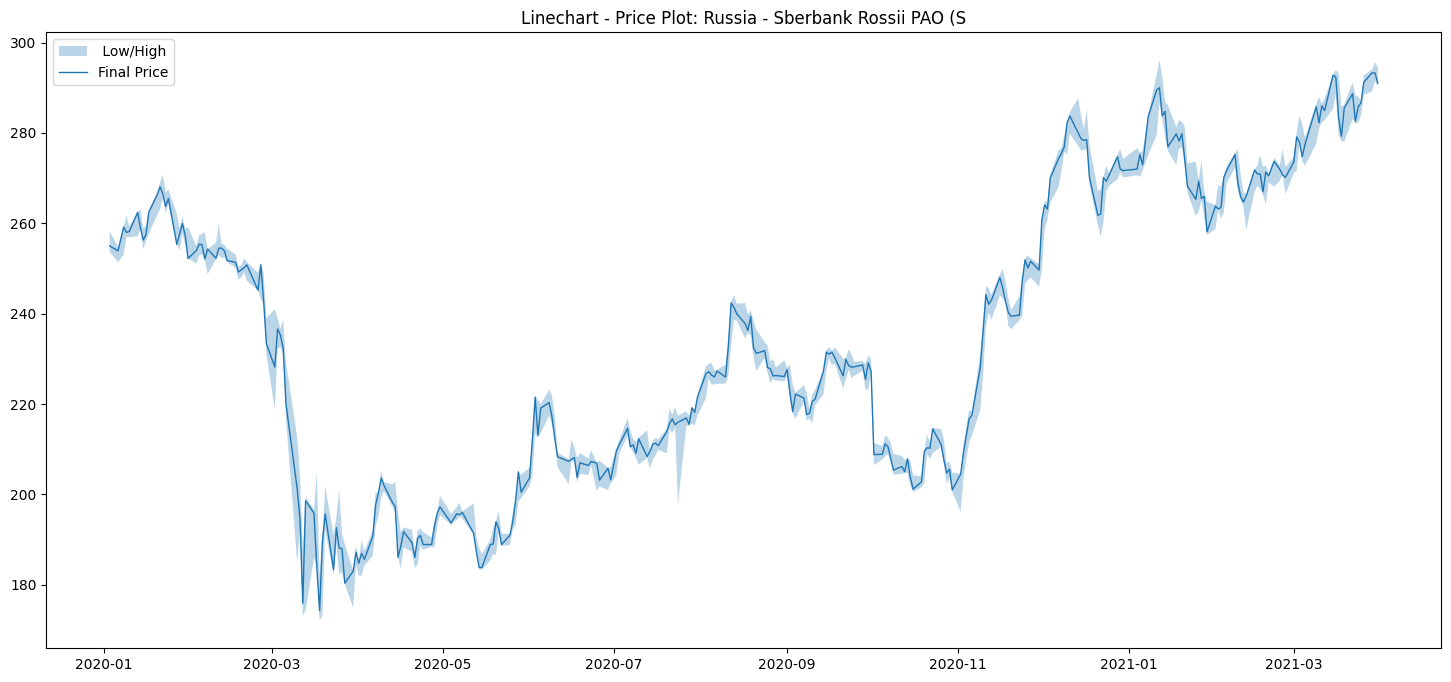

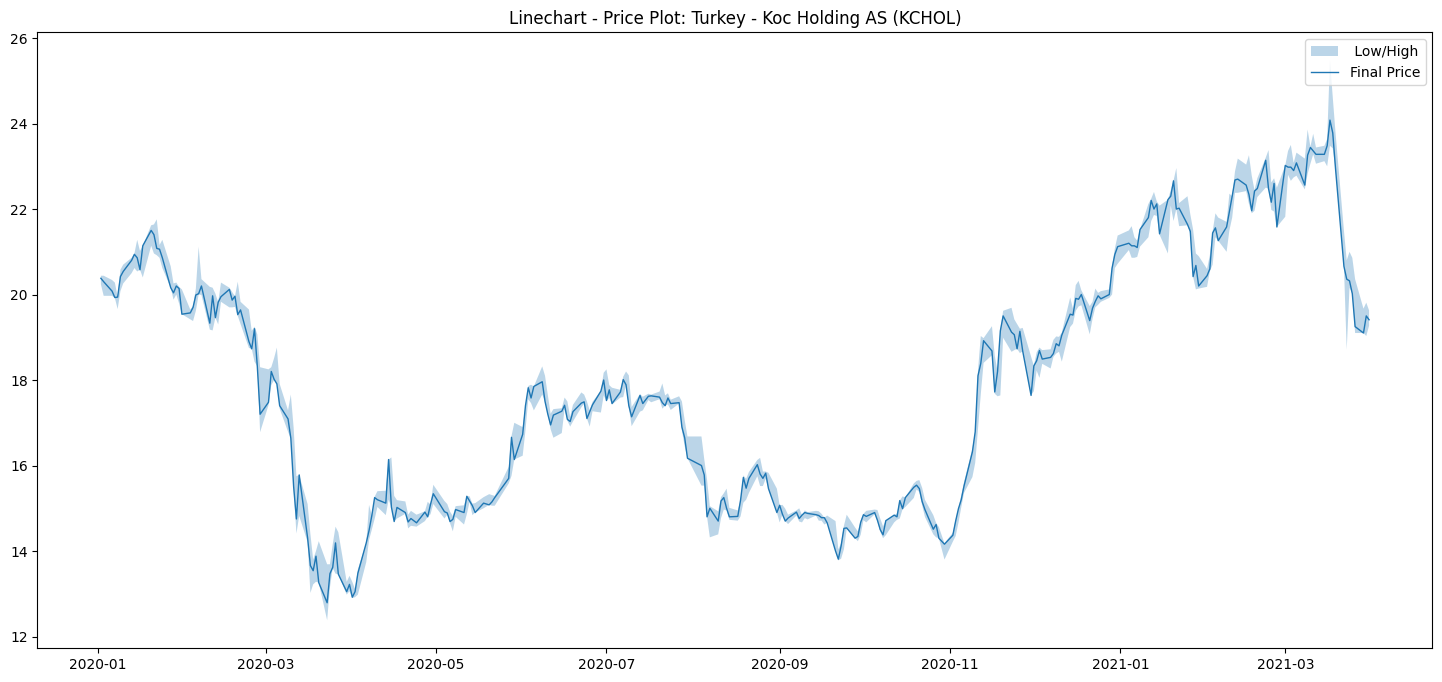

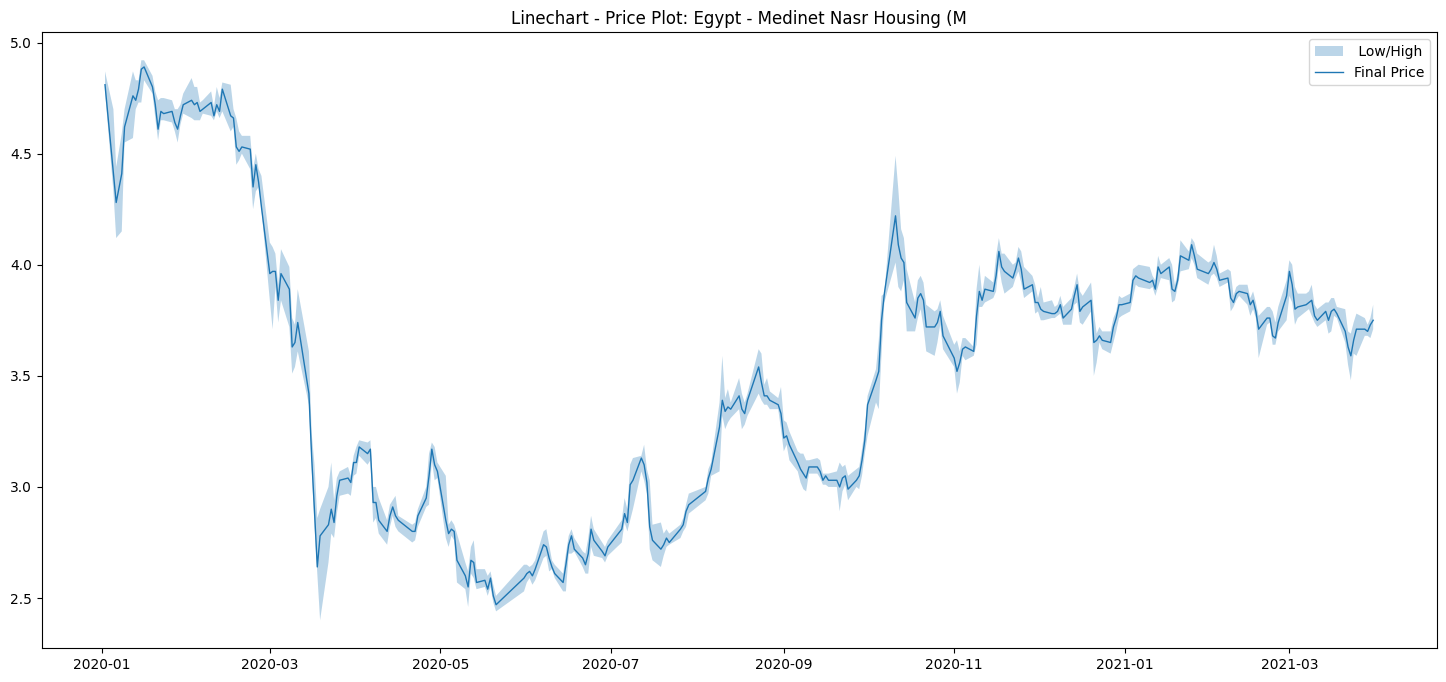

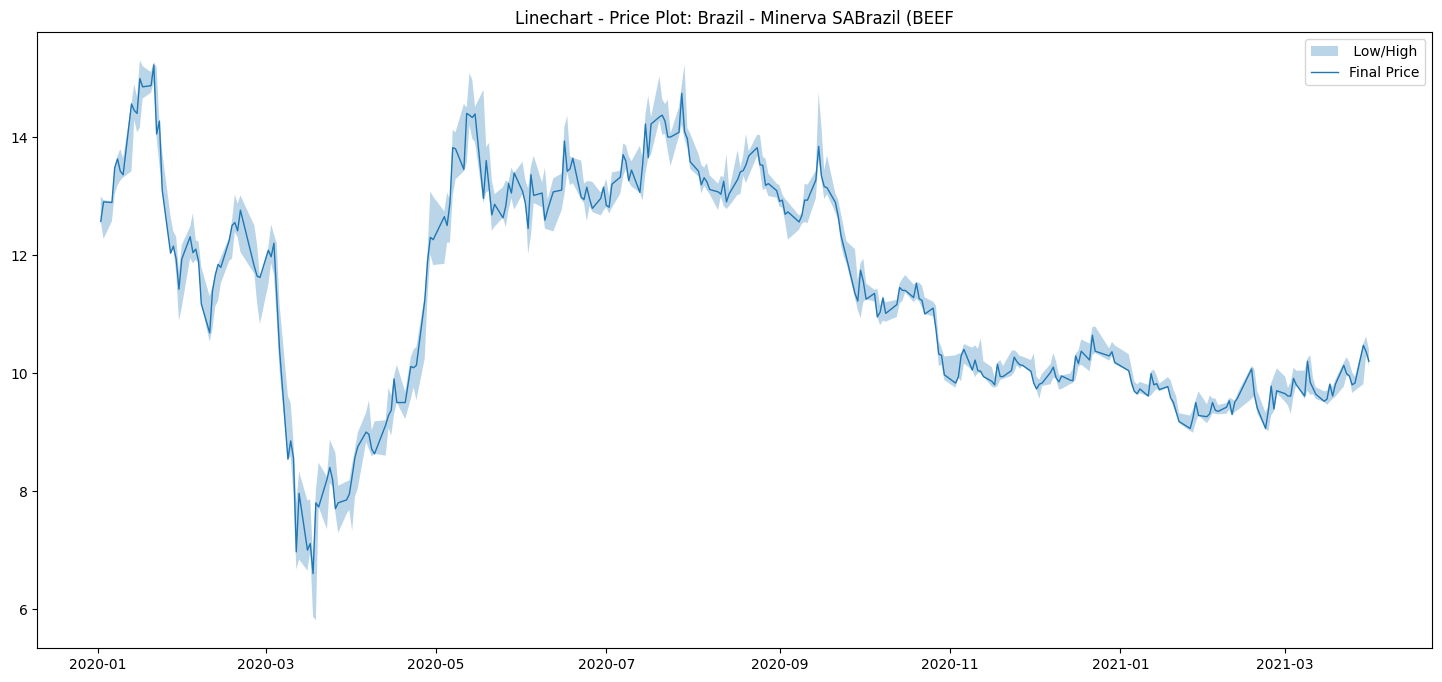

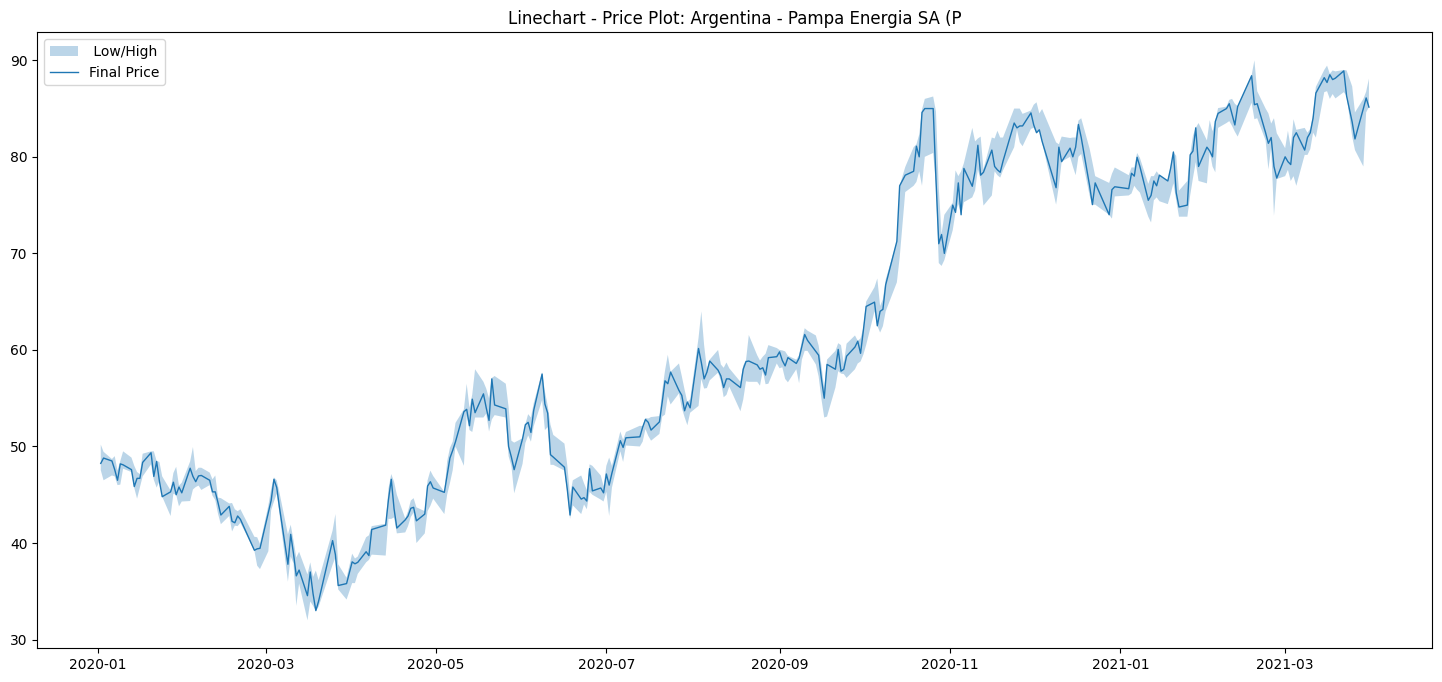

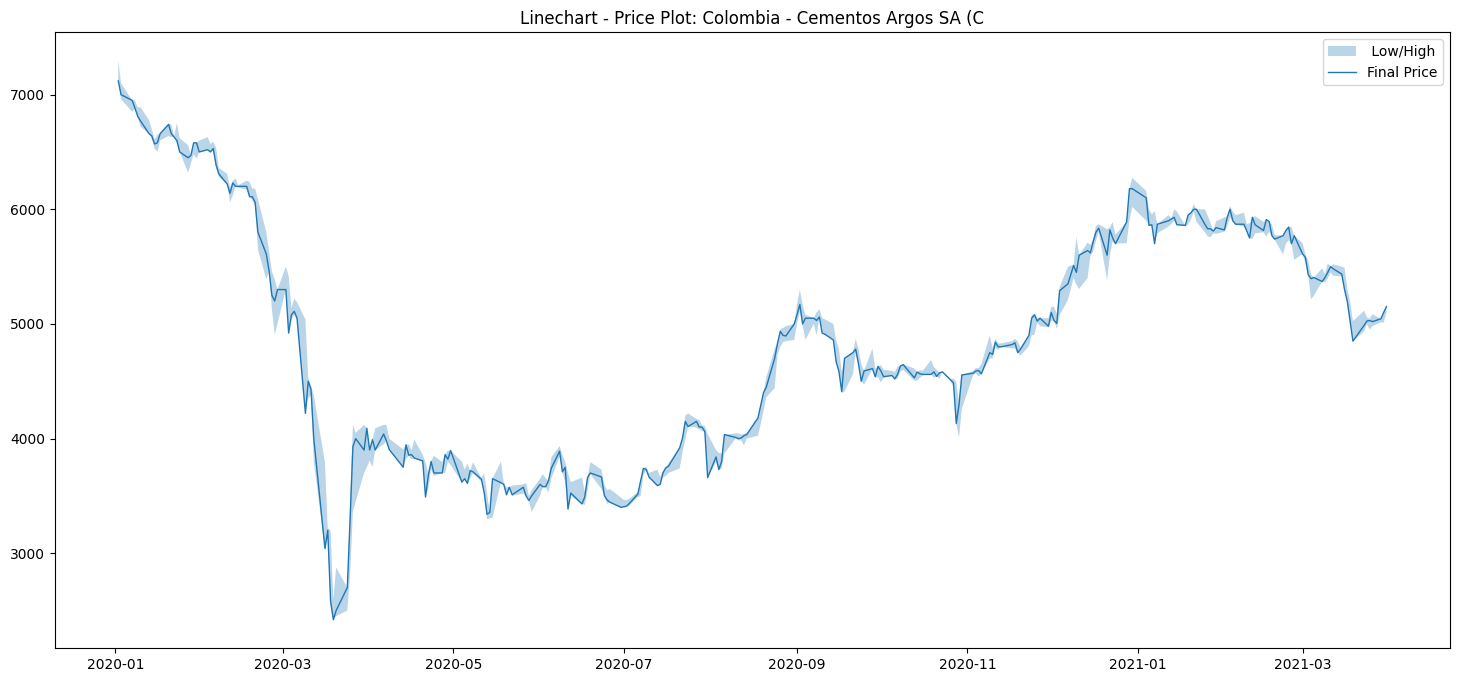

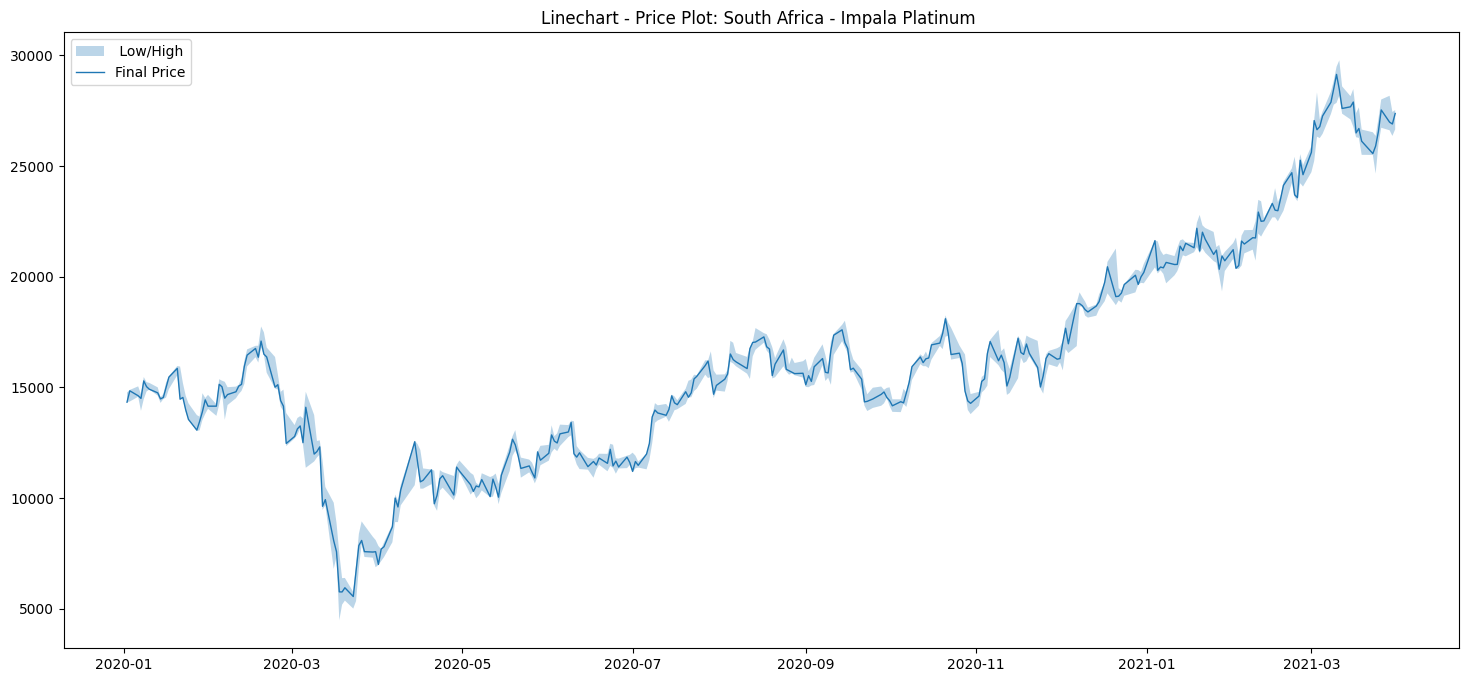

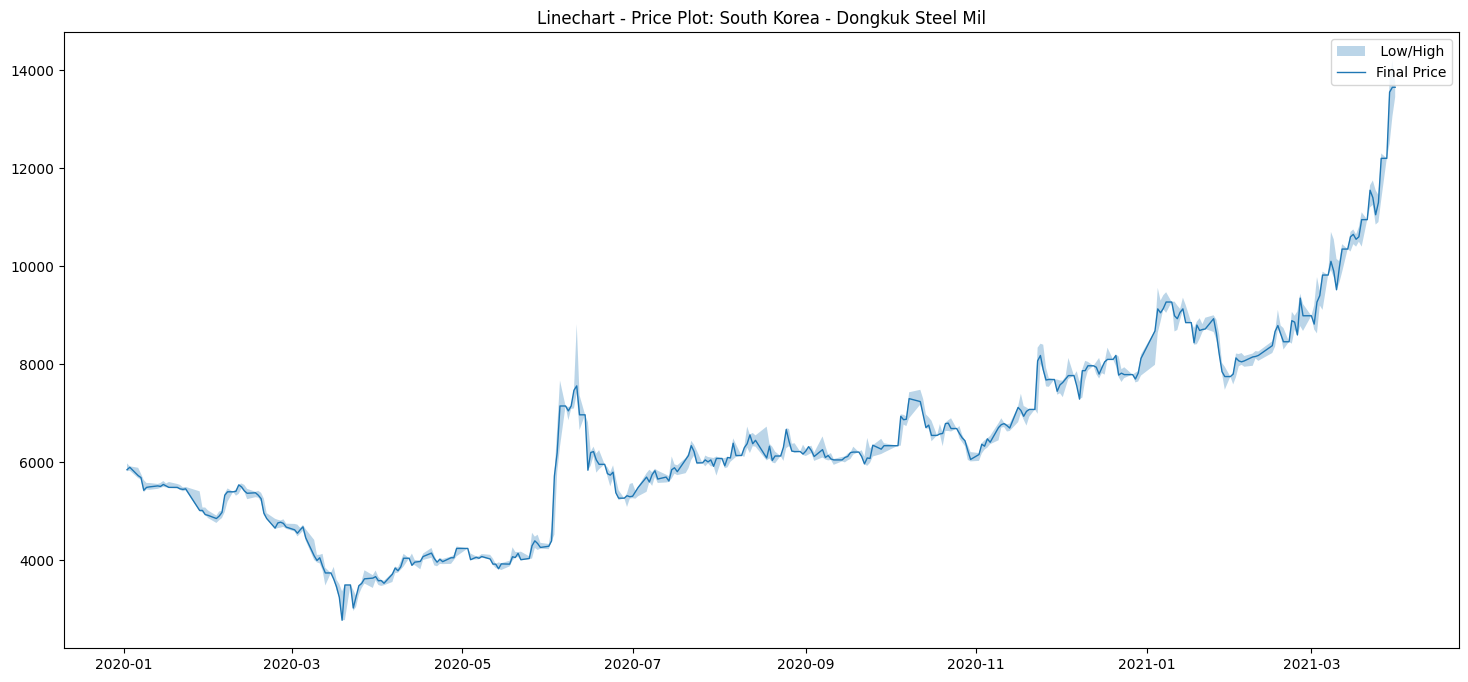

In [9]:
for key in df_dic:
    EDA_plot(df_dic[key], name = key)


Looking at the trend there are no specific outliers to evidence

### Forecasting with ARIMA

In [10]:
def ARIMA_prerun(df):

    #preprocessing the dataset for ARIMA model
    train_ARIMA = df.loc['2020', ['Price']].copy()
    test_ARIMA = df.loc['2021', ['Price']].copy()

    train_index = train_ARIMA.index
    forecast_index = test_ARIMA.index

    train_ARIMA.reset_index(drop=True,inplace=True)
    test_ARIMA.reset_index(drop=True,inplace=True)

    #Creating continous index range with day frequency
    train_ARIMA.index = pd.date_range(start='2020-01-03', periods=len(train_ARIMA), freq='D')
    test_ARIMA.index = pd.date_range(start=train_ARIMA.index[-1]+pd.Timedelta(days=1), periods=len(test_ARIMA), freq='D')

    #dickey fuller test
    dftest = adfuller(train_ARIMA['Price'])
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    labels = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(dftest,labels):
      print(label+' : '+str(value) )
    if (pvalue < 0.05) and (adf < critical_value):
      print('The series is stationary')
    else:
      print('The series is NOT stationary')

    results_1 = seasonal_decompose(train_ARIMA['Price'], model = 'additive')
    fig = plt.figure()
    fig = results_1.plot()
    fig.set_size_inches(8, 6)
    fig.show()

    return train_ARIMA, test_ARIMA, train_index, forecast_index




def ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name):

    #auto arima model
    ARIMA_model = auto_arima(train_ARIMA['Price'],
                          start_p=0,
                          start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          trace=False,
                          error_action='warn',
                          suppress_warnings=True,
                          stepwise=True)
    print("ARIMA Order:",ARIMA_model.order)

    # Forecast
    n_periods = len(test_ARIMA)
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(train_ARIMA.index[-1]+pd.Timedelta(days=1), periods =n_periods, freq='D')

    forecast_df = pd.DataFrame({'Fitted': fitted,'Lower': confint[:, 0],'Upper': confint[:, 1]}, index=index_of_fc)

    # Calculate MAPE for each forecast point
    forecast_df['MAPE'] = abs((test_ARIMA['Price'] - forecast_df['Fitted']) / test_ARIMA['Price']) * 100
    mape = forecast_df['MAPE'].mean()
    print(f"\n\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

    test_ARIMA.index = forecast_index
    train_ARIMA.index = train_index
    forecast_df.reset_index(drop = True,inplace = True)
    forecast_df.index = forecast_index

    # Plotting
    plt.figure(figsize=(15, 7))
    # plt.plot(train_ARIMA["Price"], color='Blue', label="Historic Price")
    plt.plot(test_ARIMA["Price"], color='Green', label="Actual Price")
    plt.plot(forecast_df['Fitted'], color='red', label="Forecast")
    plt.fill_between(forecast_df.index,
                    forecast_df['Lower'],
                    forecast_df['Upper'],
                    color='k', alpha=.15, label="Forecast - Low/High")

    plt.title(f"ARIMA - Forecast of Stock : {name}")
    plt.legend()
    plt.show()

    return ARIMA_model,forecast_df

Test Statistic : -1.4233235279675989
p-value : 0.5710448680935892
#Lags Used : 8
Number of Observations Used : 241
The series is NOT stationary
Russia - Sberbank Rossii PAO (S
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 2.91%


<Figure size 640x480 with 0 Axes>

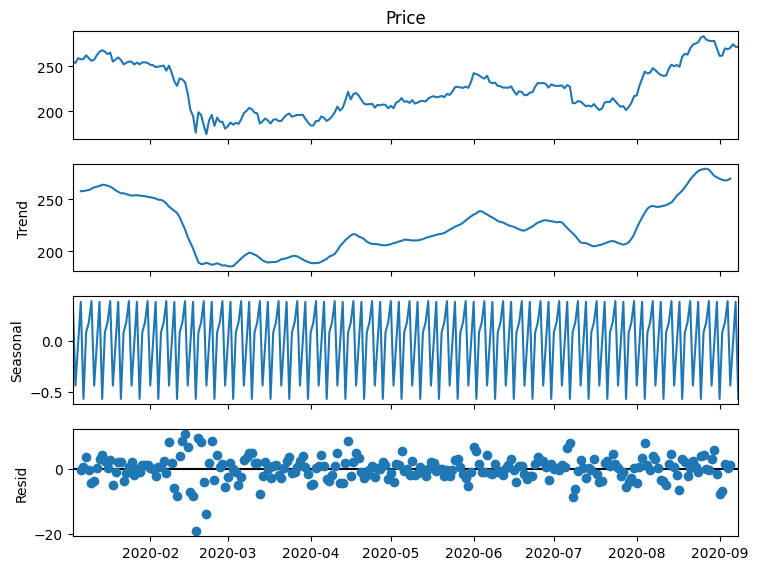

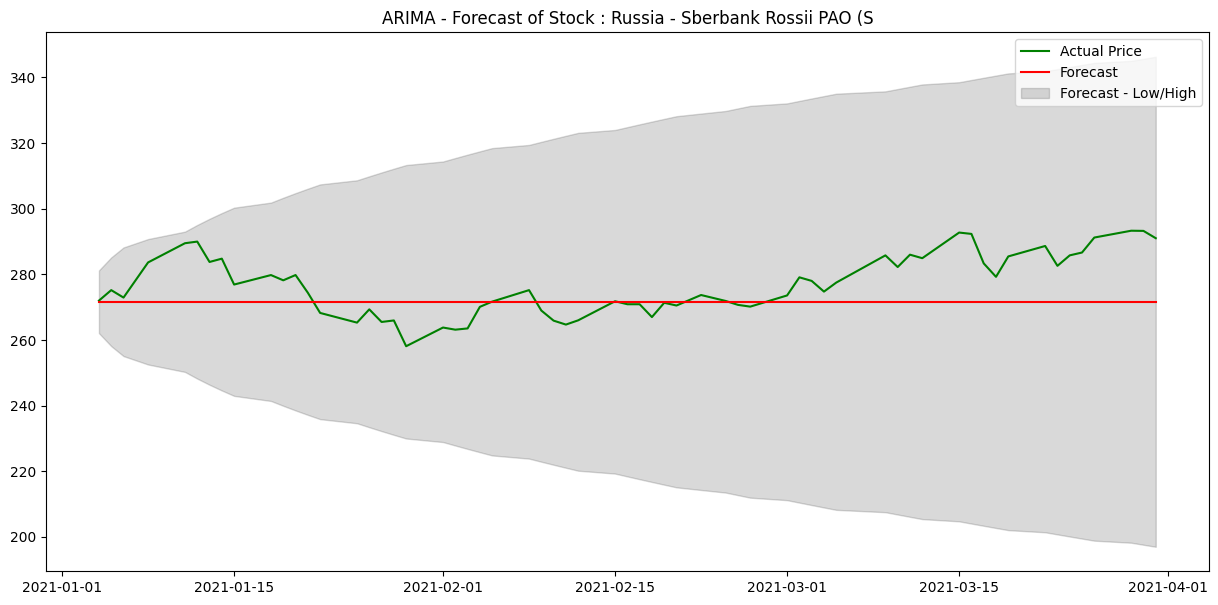

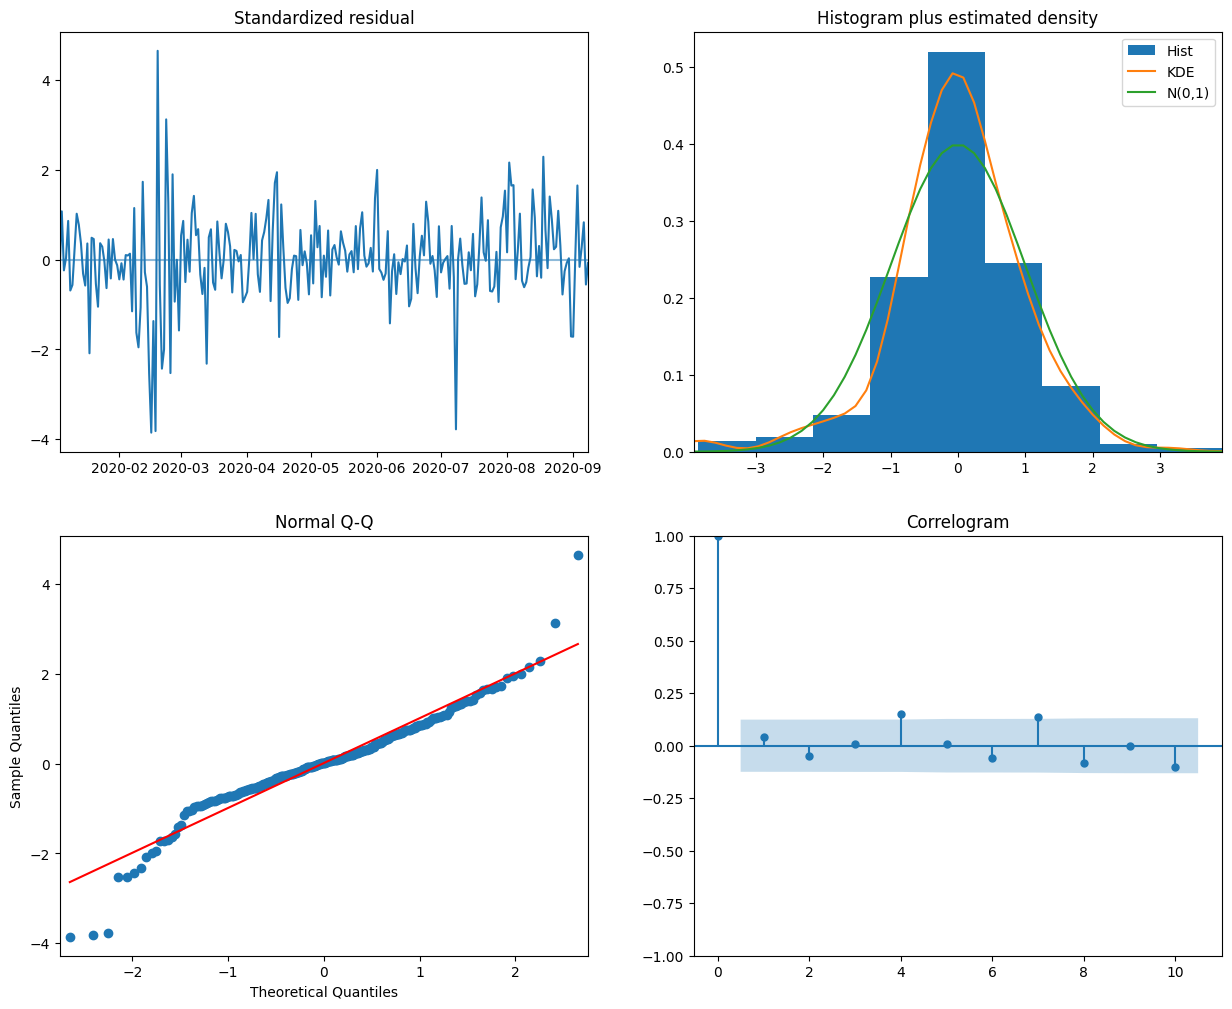

Test Statistic : -1.5241208674753024
p-value : 0.5215471446531409
#Lags Used : 4
Number of Observations Used : 247
The series is NOT stationary
Turkey - Koc Holding AS (KCHOL)
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 5.38%


<Figure size 640x480 with 0 Axes>

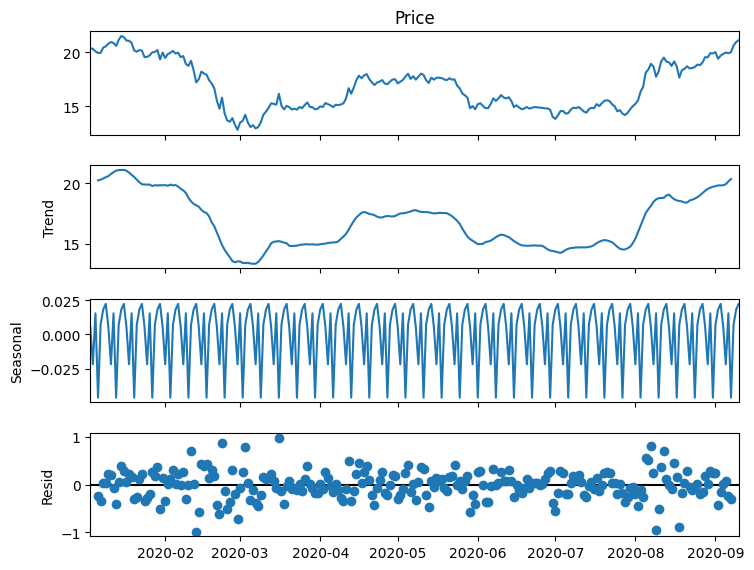

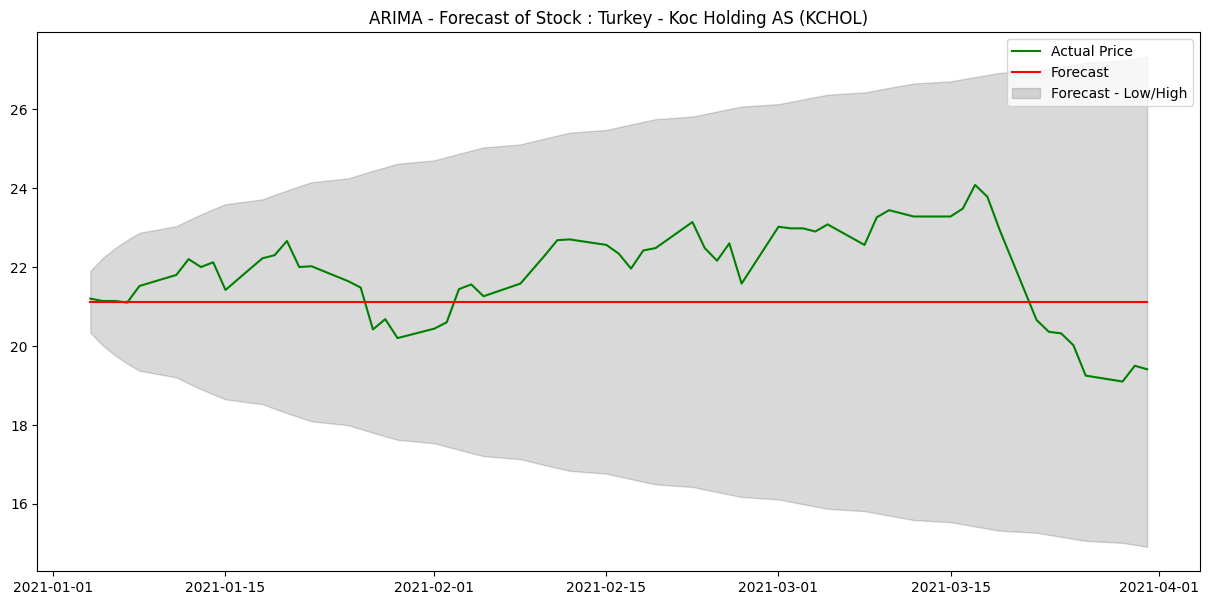

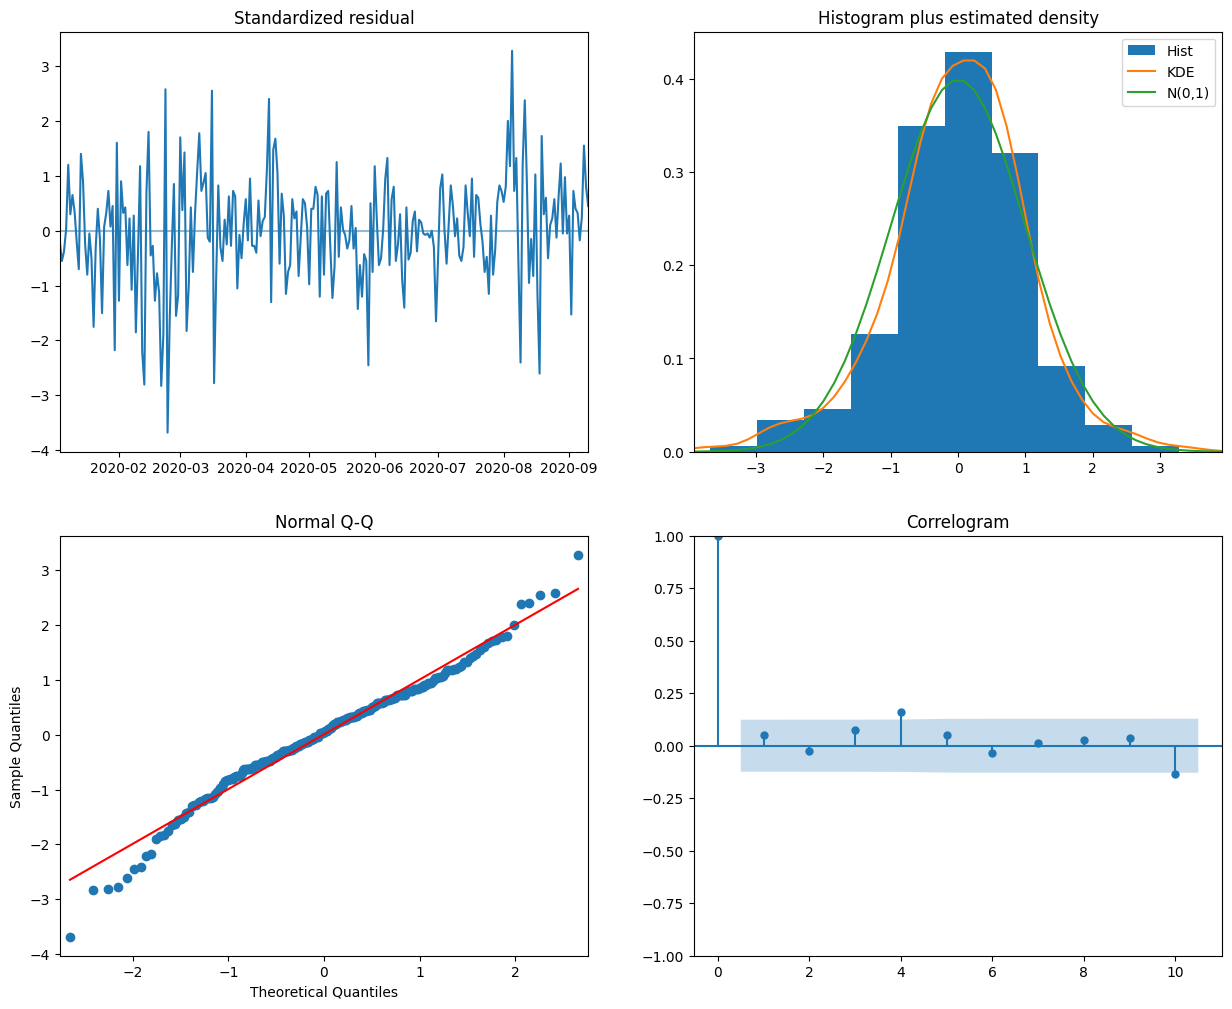

Test Statistic : -1.5424176782779746
p-value : 0.5124333991631933
#Lags Used : 1
Number of Observations Used : 241
The series is NOT stationary
Egypt - Medinet Nasr Housing (M
ARIMA Order: (1, 1, 0)


Mean Absolute Percentage Error (MAPE): 2.51%


<Figure size 640x480 with 0 Axes>

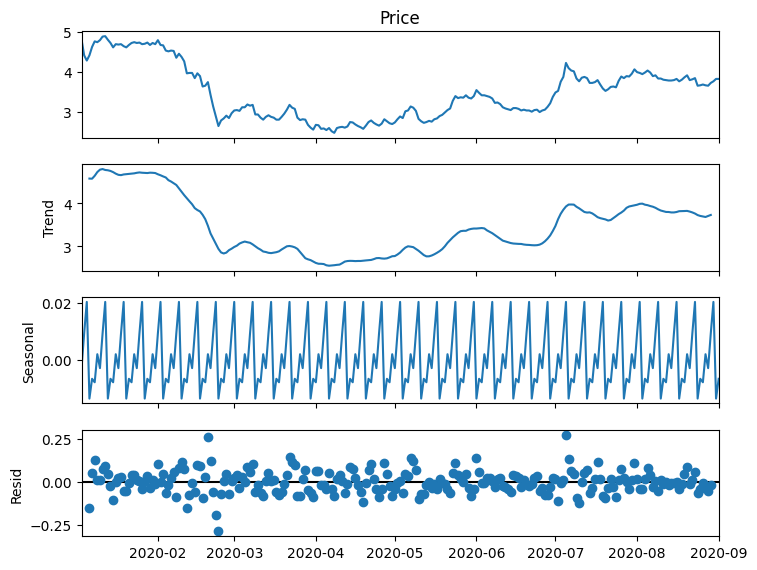

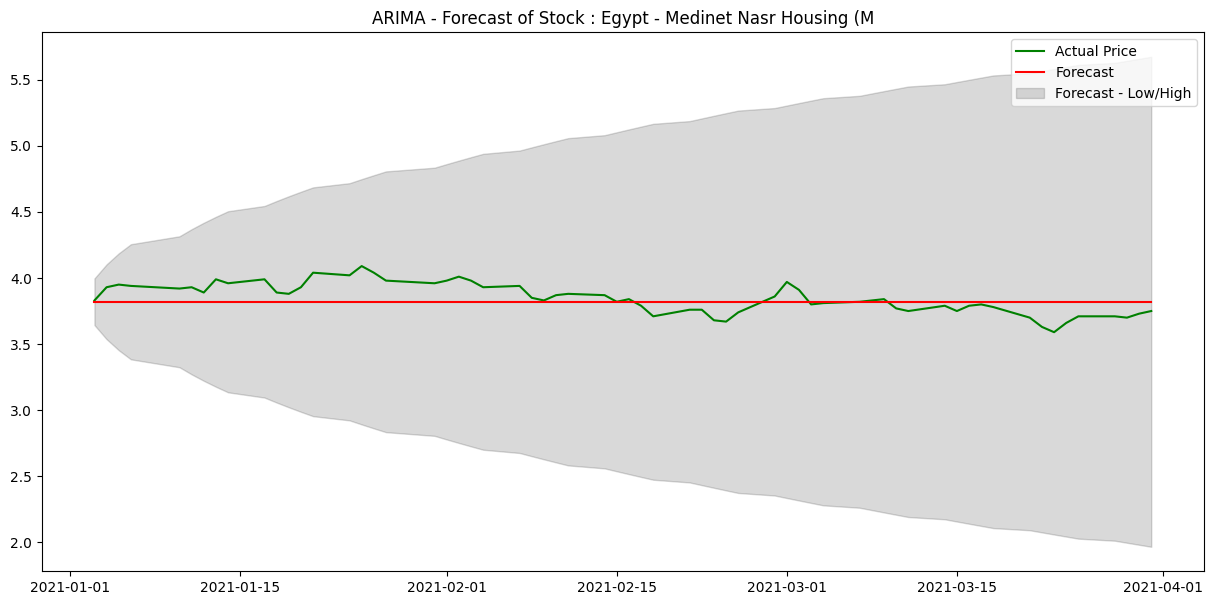

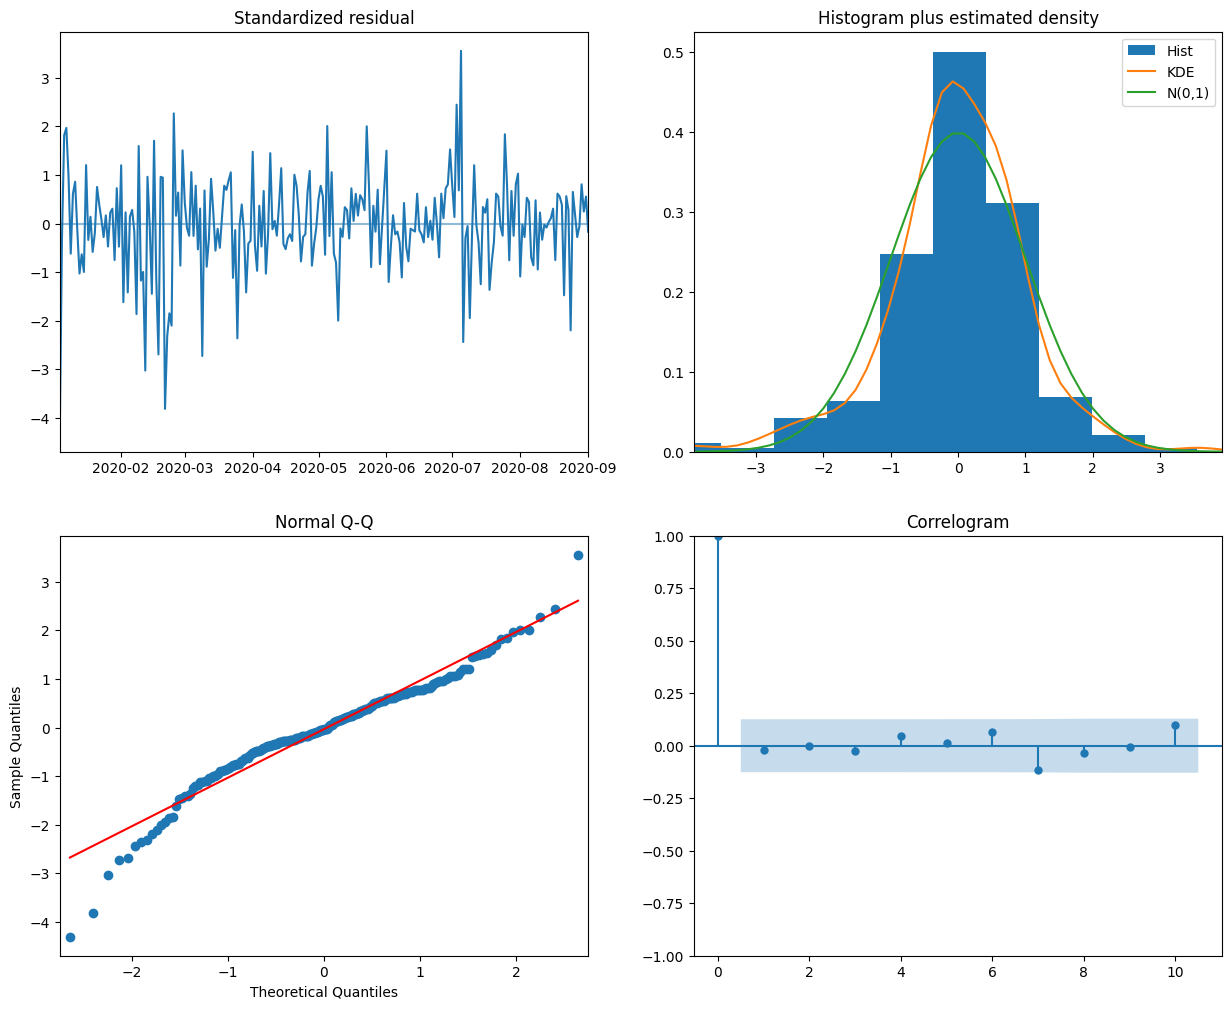

Test Statistic : -2.1956983927966993
p-value : 0.20781039501227272
#Lags Used : 3
Number of Observations Used : 245
The series is NOT stationary
Brazil - Minerva SABrazil (BEEF
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 5.66%


<Figure size 640x480 with 0 Axes>

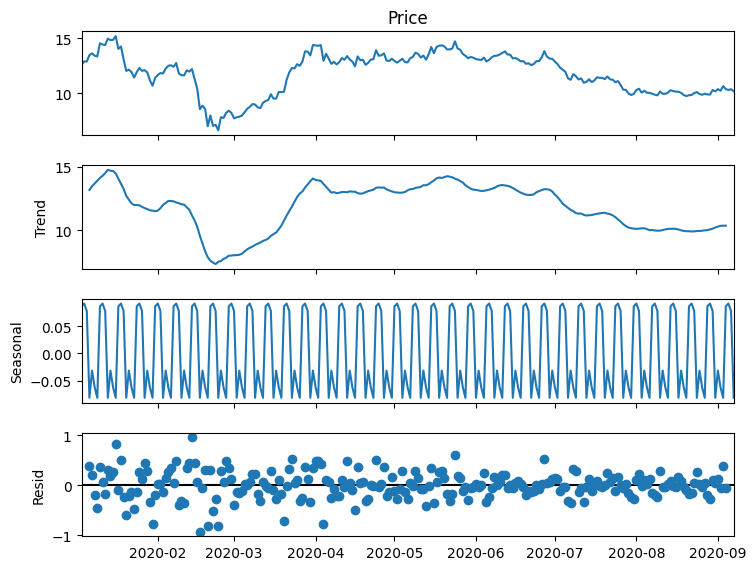

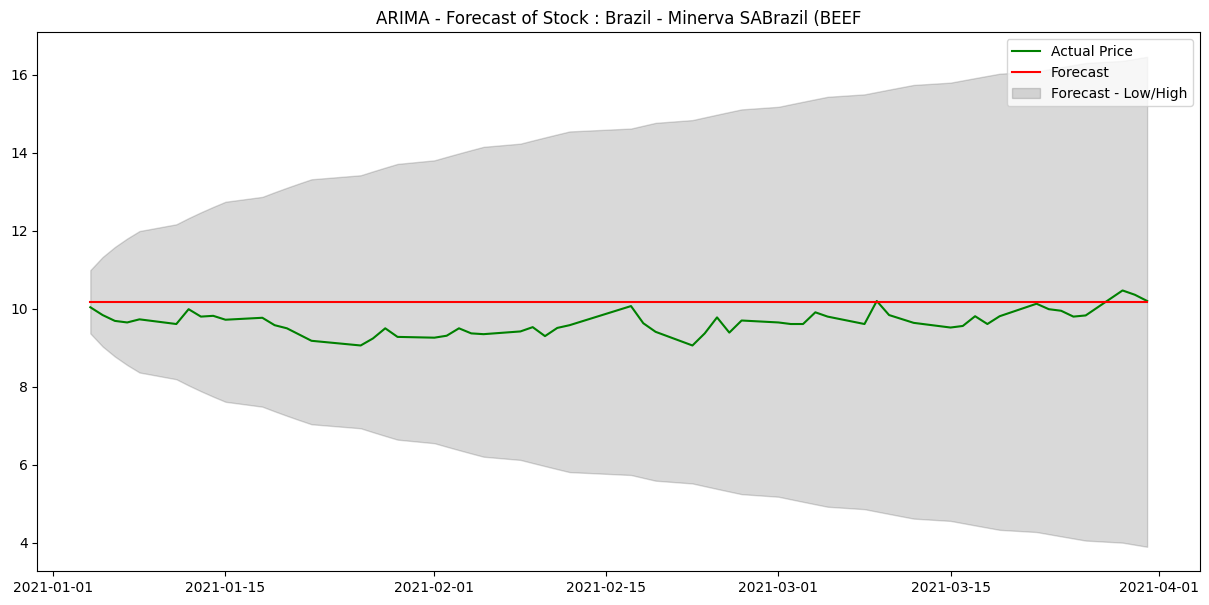

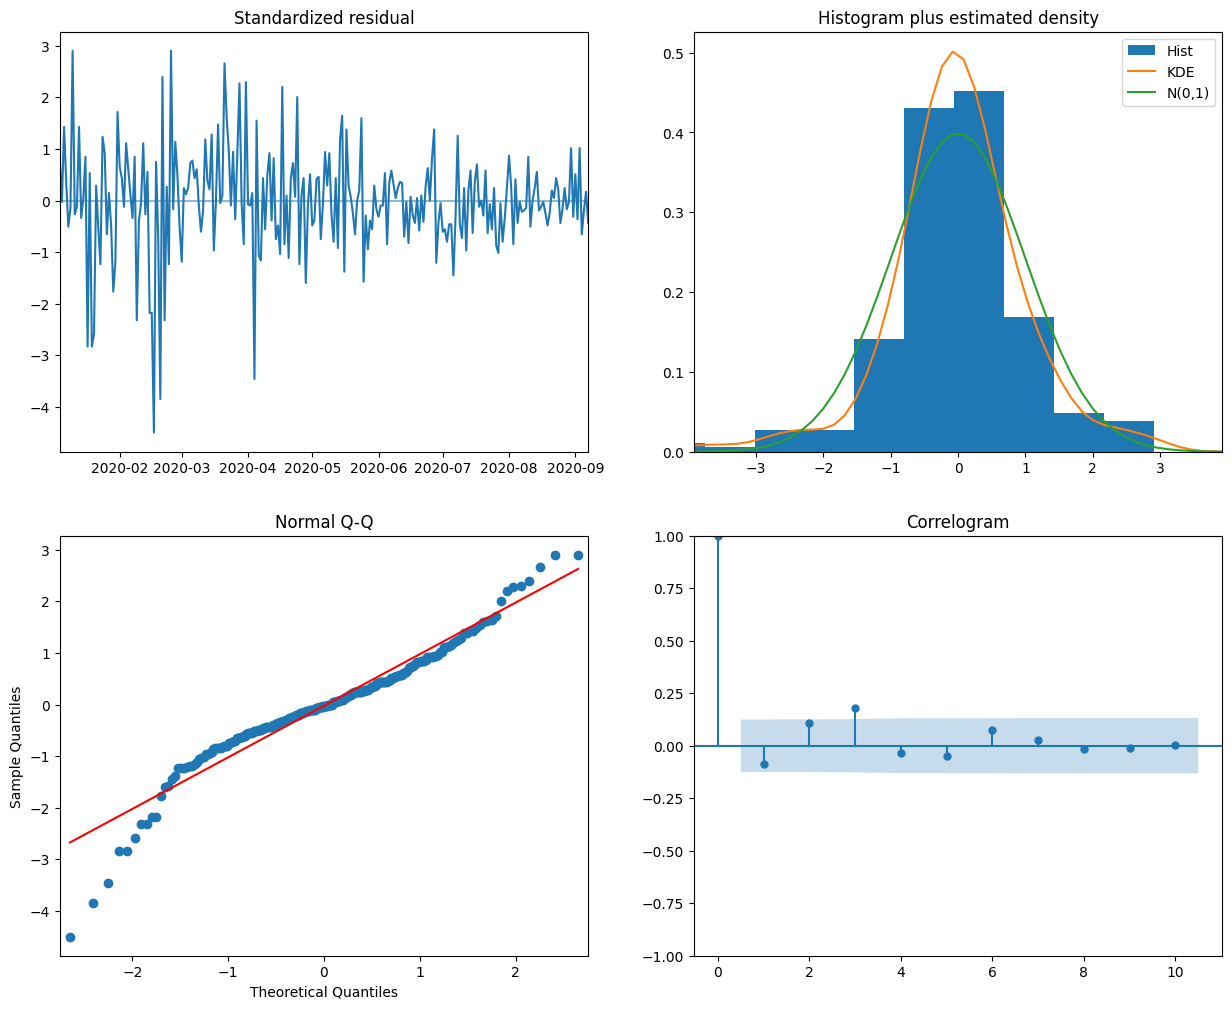

Test Statistic : -0.7426681664185703
p-value : 0.8353858829030216
#Lags Used : 0
Number of Observations Used : 239
The series is NOT stationary
Argentina - Pampa Energia SA (P
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 6.20%


<Figure size 640x480 with 0 Axes>

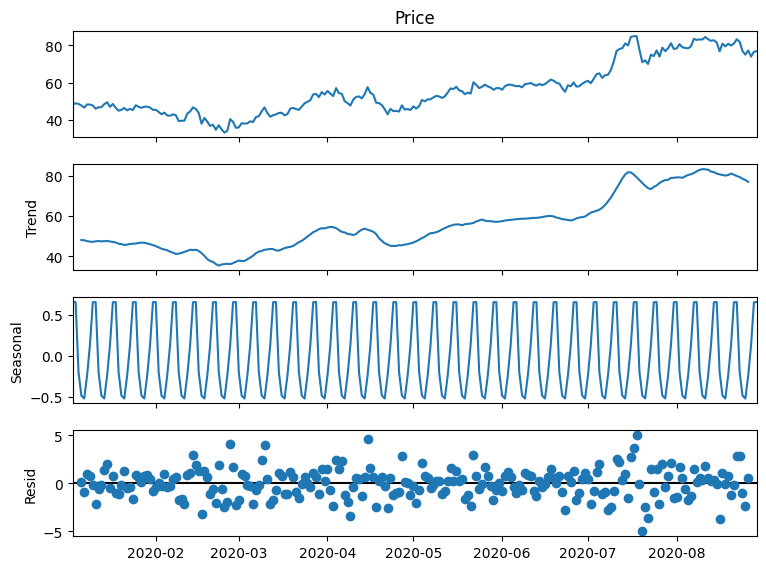

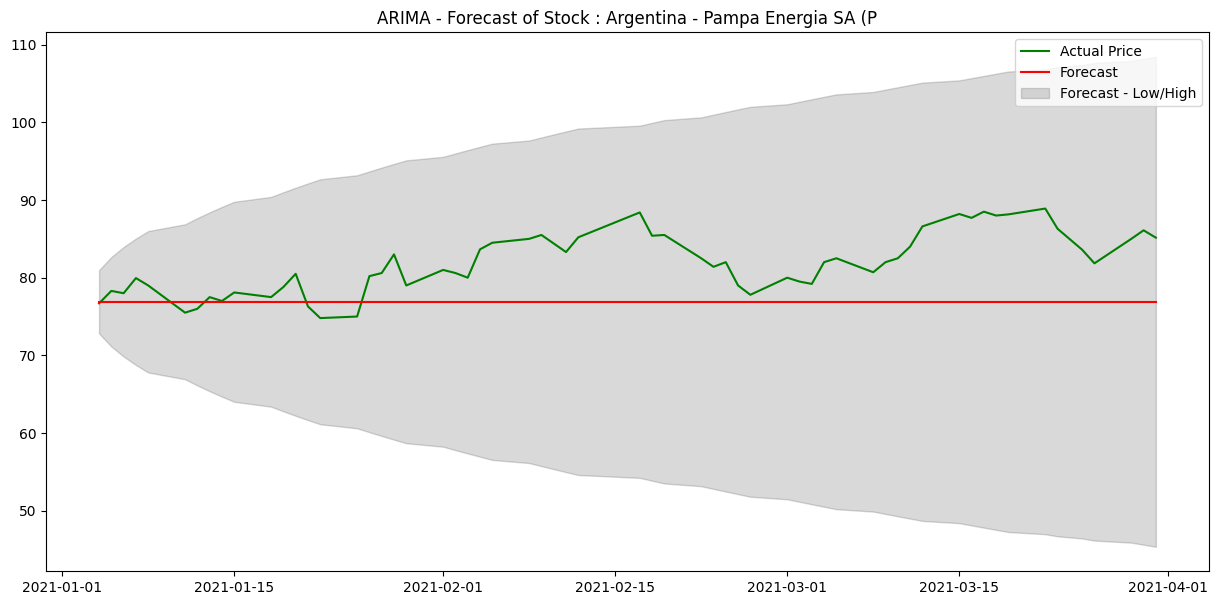

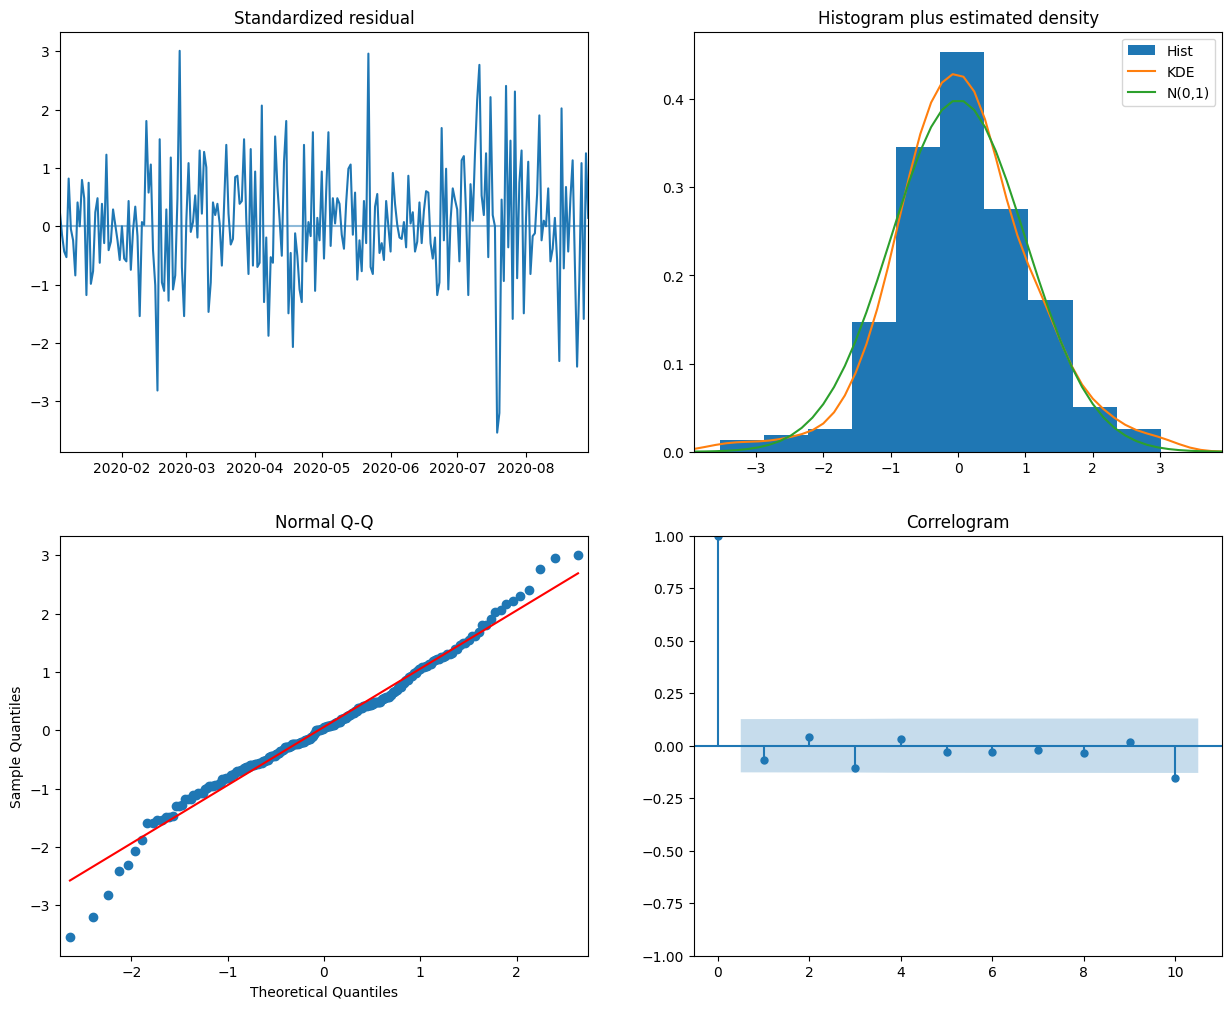

Test Statistic : -1.8521235185530325
p-value : 0.35490774277987824
#Lags Used : 5
Number of Observations Used : 236
The series is NOT stationary
Colombia - Cementos Argos SA (C
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 9.81%


<Figure size 640x480 with 0 Axes>

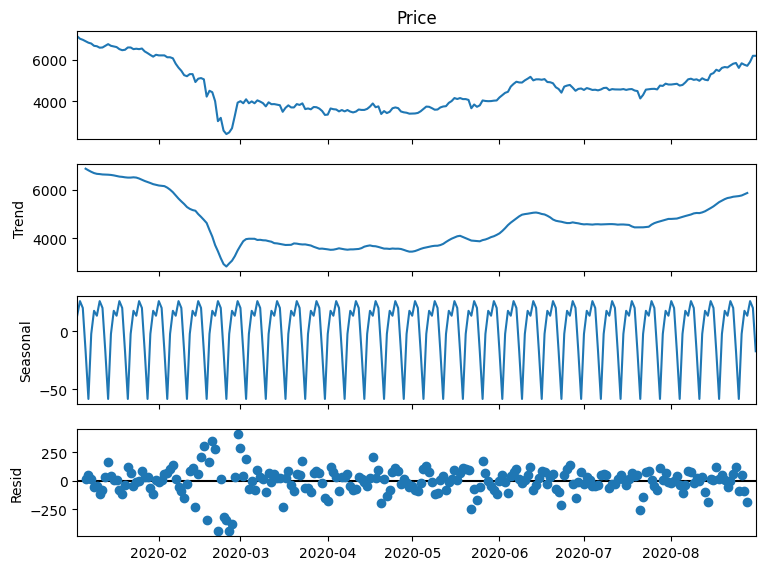

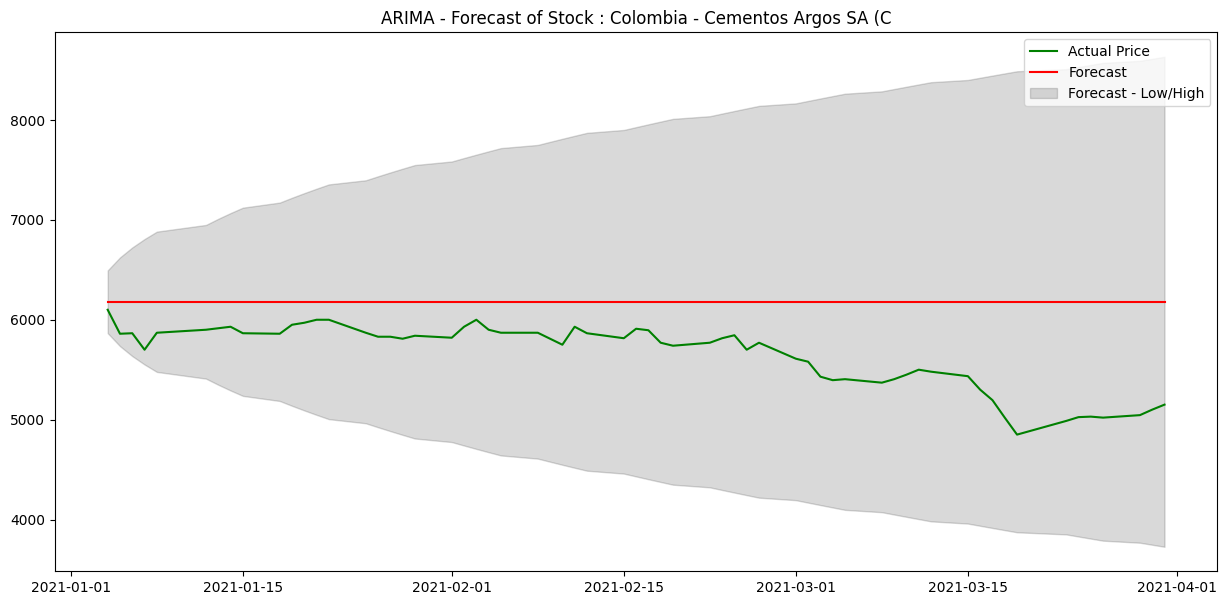

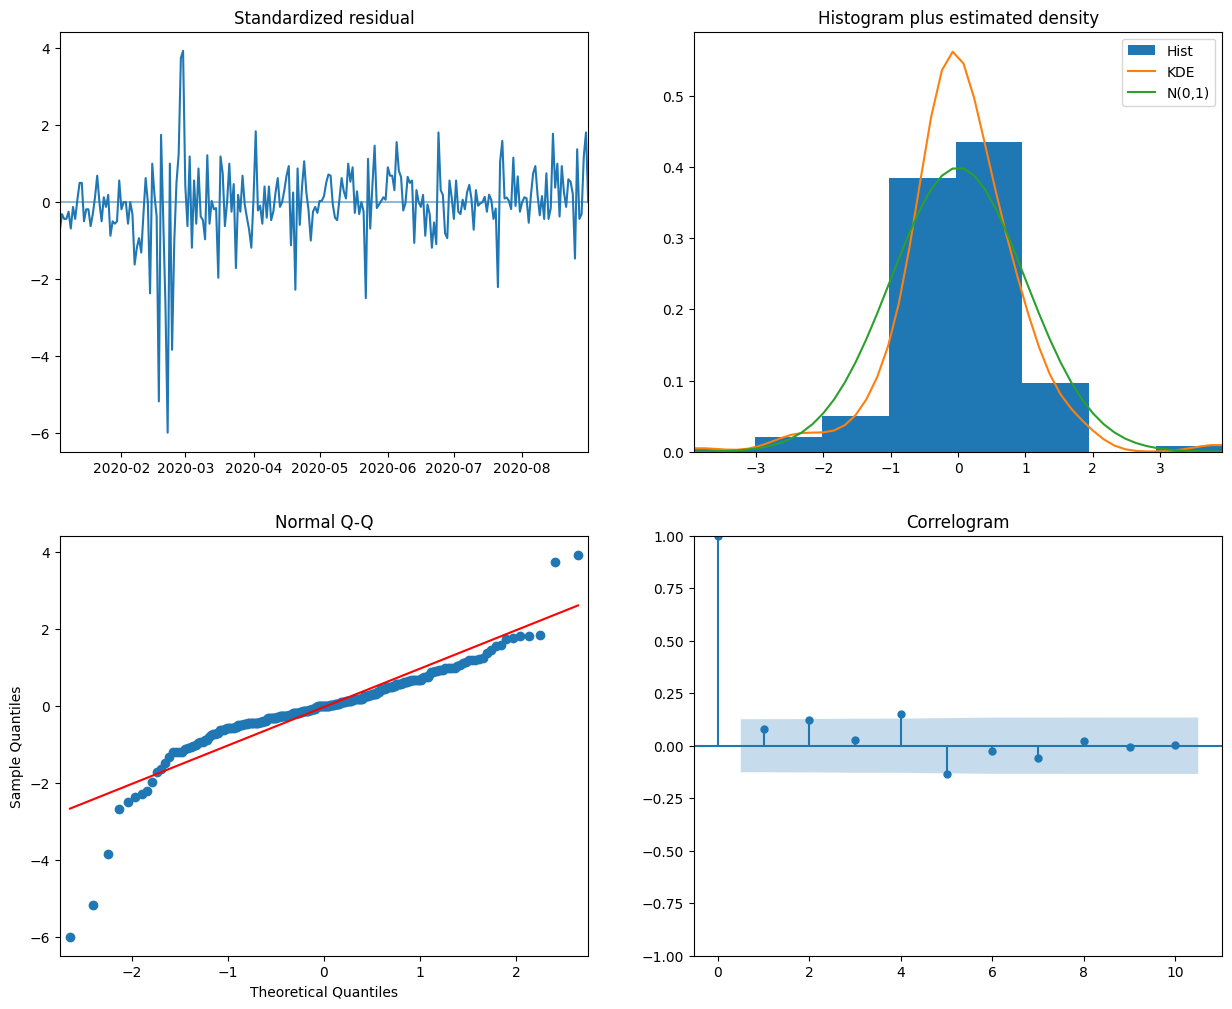

Test Statistic : -0.910445838788536
p-value : 0.7845129916264035
#Lags Used : 6
Number of Observations Used : 245
The series is NOT stationary
South Africa - Impala Platinum 
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 13.90%


<Figure size 640x480 with 0 Axes>

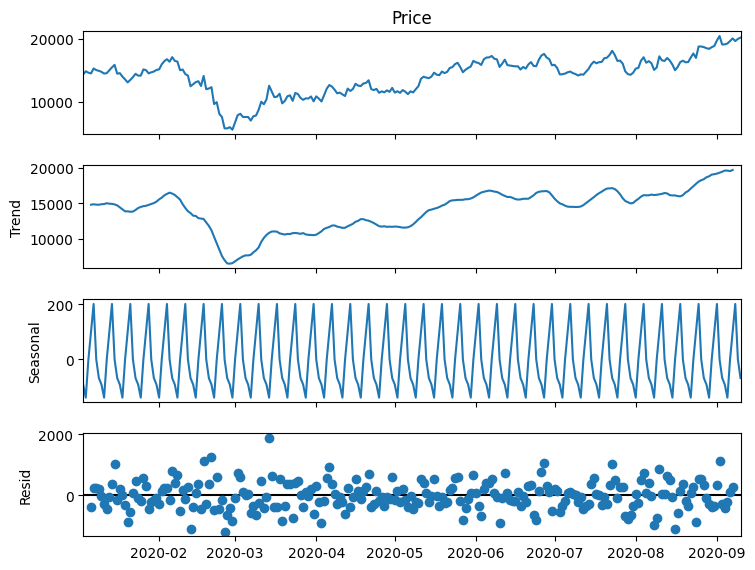

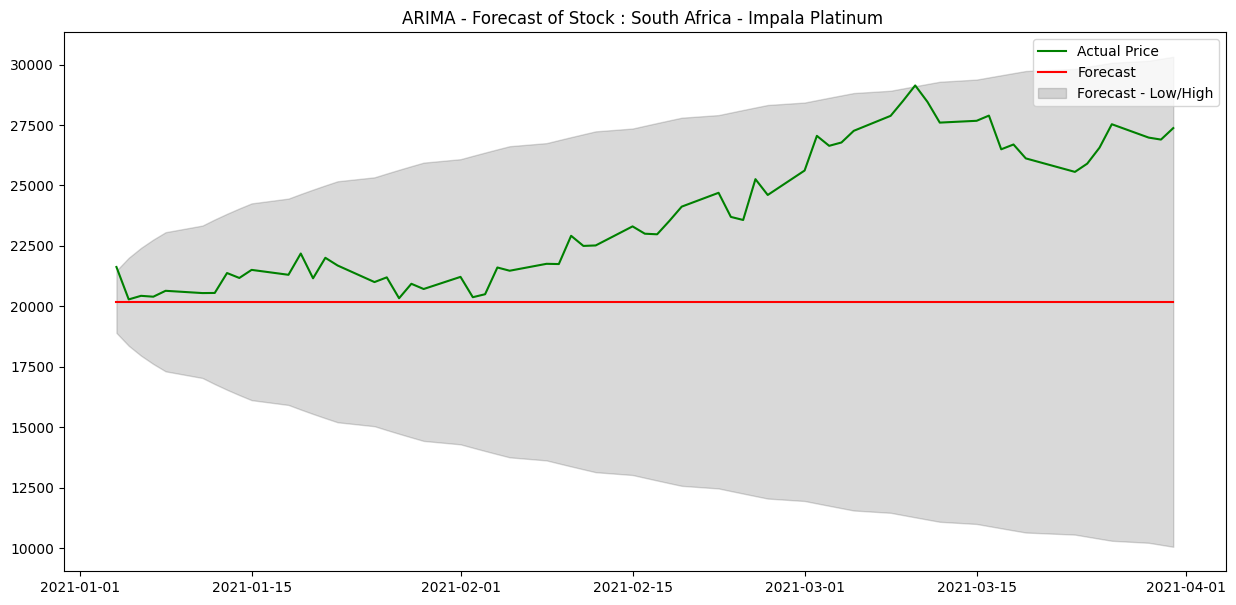

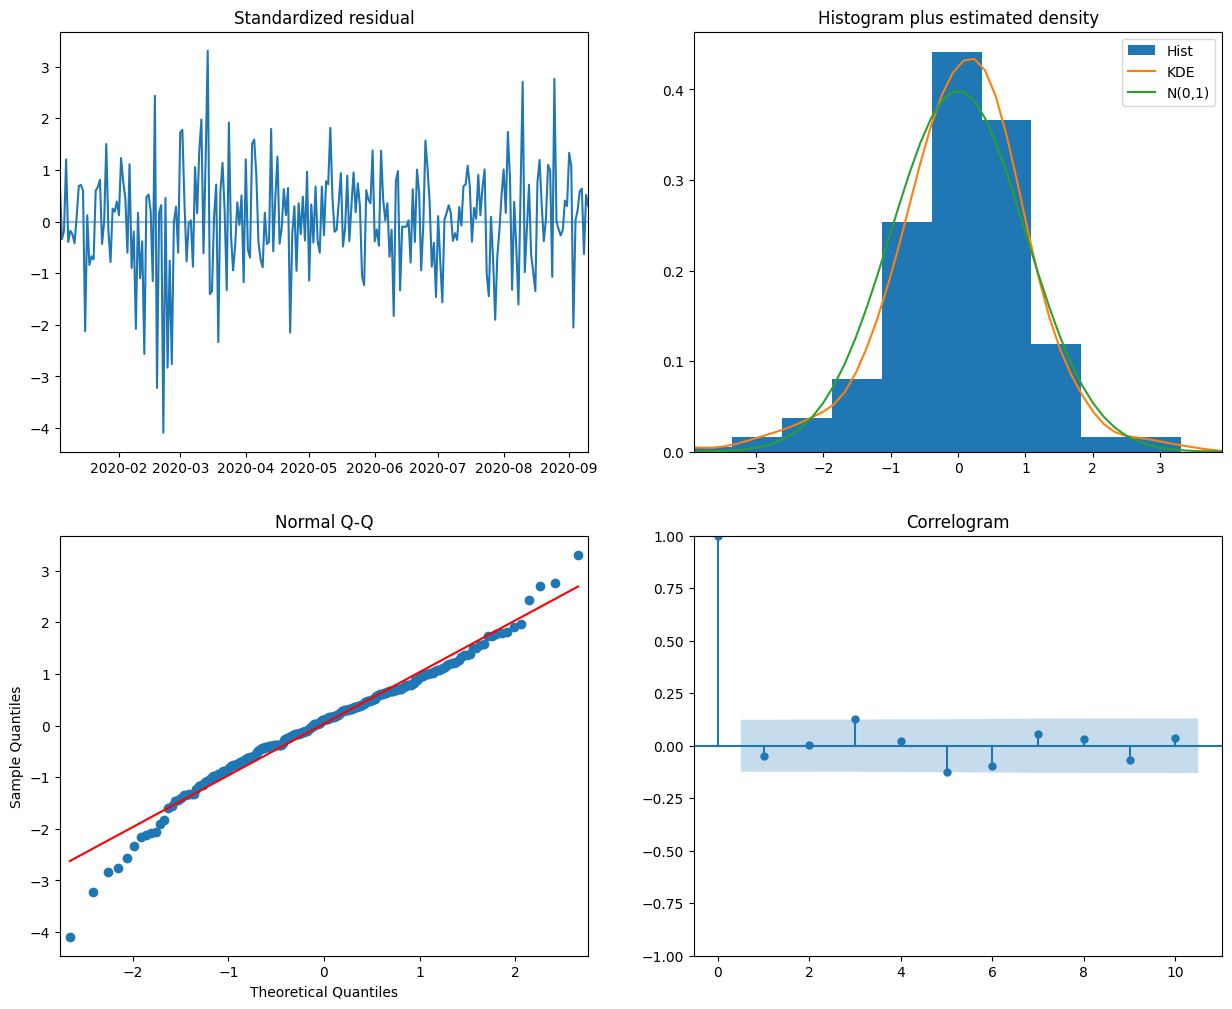

Test Statistic : -0.7325649461744608
p-value : 0.8381332296792271
#Lags Used : 0
Number of Observations Used : 271
The series is NOT stationary
South Korea - Dongkuk Steel Mil
ARIMA Order: (0, 1, 0)


Mean Absolute Percentage Error (MAPE): 13.10%


<Figure size 640x480 with 0 Axes>

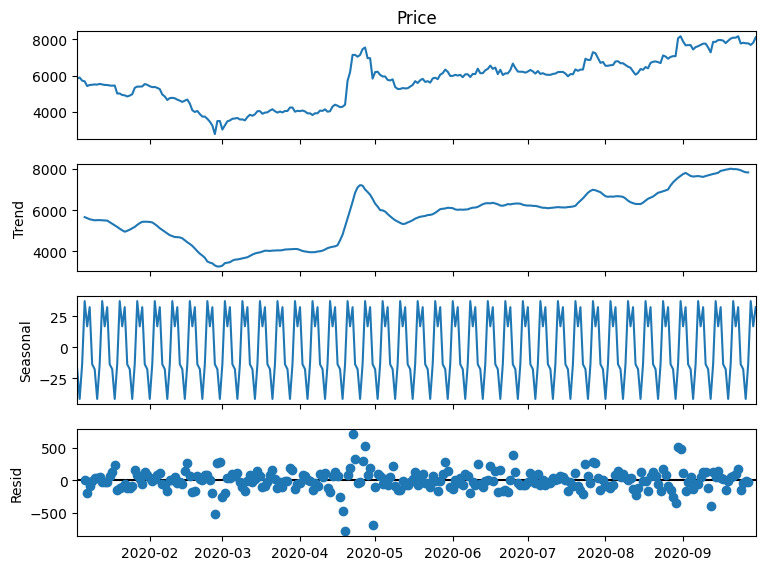

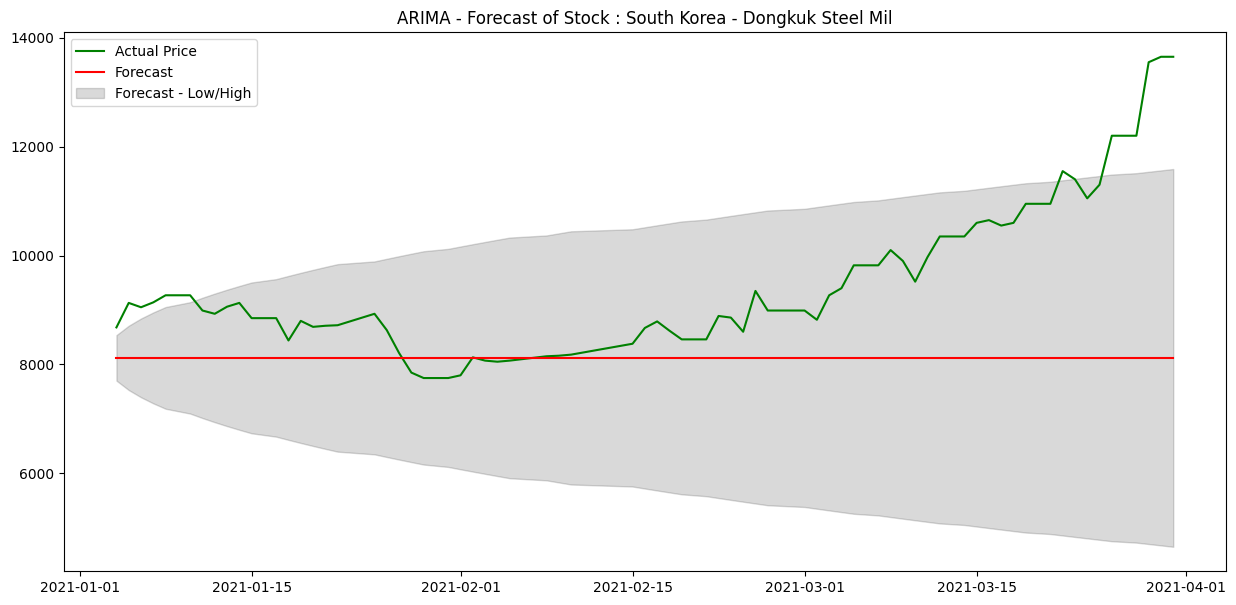

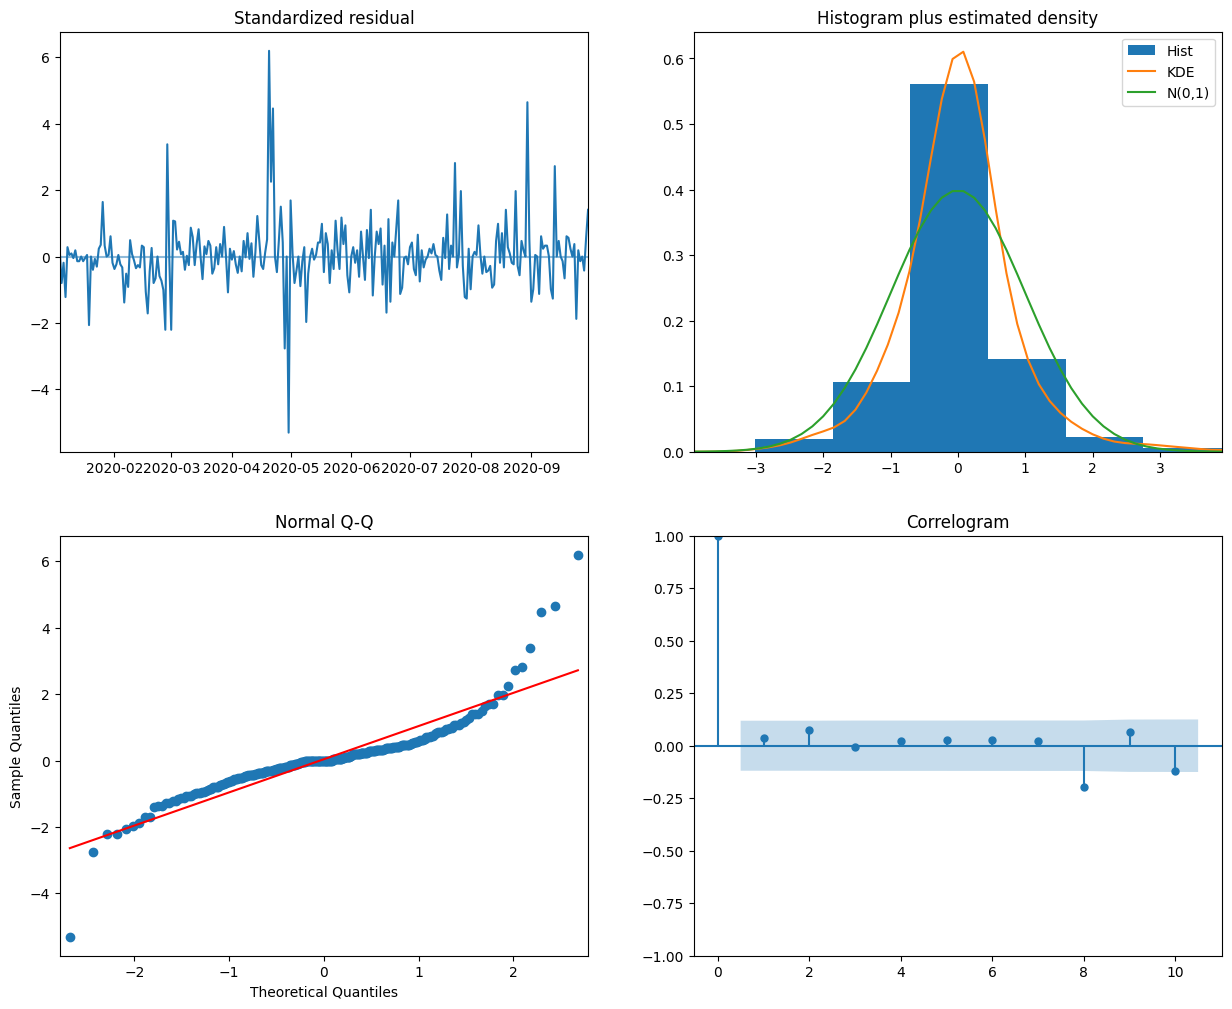

In [11]:
for key in df_dic:
    train_ARIMA, test_ARIMA, train_index, forecast_index = ARIMA_prerun(df_dic[key])
    print(key)
    ARIMA_model,forecast_df = ARIMA_forecast(train_ARIMA, test_ARIMA, train_index, forecast_index,name=key)
    ARIMA_model.plot_diagnostics(figsize=(15,12))
    plt.show()

ARIMA performs generally well with linear trends and stationary time series detecting also seasonality. It is less efficient with not linear trend making it unsuitable for forecasting complex trends like  stock prices.

### Forecasting with LSTM

In [12]:

K.clear_session()
scaler =  MinMaxScaler()

#prepraing the data for LSTM model

def df_to_X_y(df, window_size):
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = df[i:i+window_size]
    X.append(row)
    label = df[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)


#bulding and training LSTM model

def lstm(df,name):

    window_size = 5

    #scaling the datasent
    scaled = scaler.fit_transform(df[['Price']])
    # test_LSTM_scaled = scaler.transform(df.loc['2021',['Price']])

    #converting to tensors
    X1, y1, = df_to_X_y(scaled,window_size)
    # X_test, y_test = df_to_X_y(test_LSTM_scaled,window_size)

    #spliting train and val set
    # train_len = len(df[df.index.year == 2020])
    # val_len = int((1-.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    train_len = len(df[df.index.year == 2020]) - window_size
    val_len = int((1 - 0.2) * train_len)
    # test_len = len(df[df.index.year == 2021])

    X_train, y_train = X1[:val_len], y1[:val_len]
    X_val, y_val = X1[val_len:train_len], y1[val_len:train_len]
    X_test, y_test = X1[train_len:], y1[train_len:]



    #shapes
    print("scaled price dataset",scaled.shape)
    print("scaled tensor",X1.shape, y1.shape)
    print("training",X_train.shape, y_train.shape)
    print("validation",X_val.shape, y_val.shape)
    print("test",X_test.shape, y_test.shape)

    #bulding the LSTM model
    model_lstm = Sequential()
    model_lstm.add(InputLayer((5, 1)))
    model_lstm.add(LSTM(64))
    model_lstm.add(Dense(1, 'linear'))
    model_lstm.summary()

    model_lstm.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

    cp = ModelCheckpoint('model_lstm.keras', save_best_only=True)

    #model fitting
    model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

    #recalling the best model
    model_lstm_best = load_model('model_lstm.keras')

    #forecast
    test_predictions = model_lstm_best.predict(X_test).flatten()

    # Inverse transform to the original scale
    y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predictions_original_scale = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

    original_index = df.loc['2021', 'Price'].index

    test_results = pd.DataFrame(data={'Test_Predictions': predictions_original_scale, 'Actuals': y_test_original_scale}, index=original_index)
    test_results.index = pd.to_datetime(test_results.index)

    test_results['APE'] = np.abs((test_results['Actuals'] - test_results['Test_Predictions']) / test_results['Actuals']) * 100
    mape_forecast = np.mean(test_results['APE'])
    print(f"MAPE: {mape_forecast:.2f}%")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(test_results['Actuals'], color='Green', label="Actual Price")
    plt.plot(test_results['Test_Predictions'], color='red', label="Forecast")
    plt.title(f"LSTM - Forecast of Stock : {name}")
    plt.legend()
    plt.show()
    model_lstm_best.save(f"{name}_model.keras")
    return model_lstm_best,test_results


In [13]:
lstm_model = {}  # Empty dictionary
forecast_lstm ={}

Russia - Sberbank Rossii PAO (S
scaled price dataset (311, 1)
scaled tensor (306, 5, 1) (306, 1)
training (196, 5, 1) (196, 1)
validation (49, 5, 1) (49, 1)
test (61, 5, 1) (61, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1659 - root_mean_squared_error: 0.4072 - val_loss: 0.3106 - val_root_mean_squared_error: 0.5573
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0953 - root_mean_squared_error: 0.3084 - val_loss: 0.1648 - val_root_mean_squared_error: 0.4060
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0415 - root_mean_squared_error: 0.2031 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075 - root_mean_

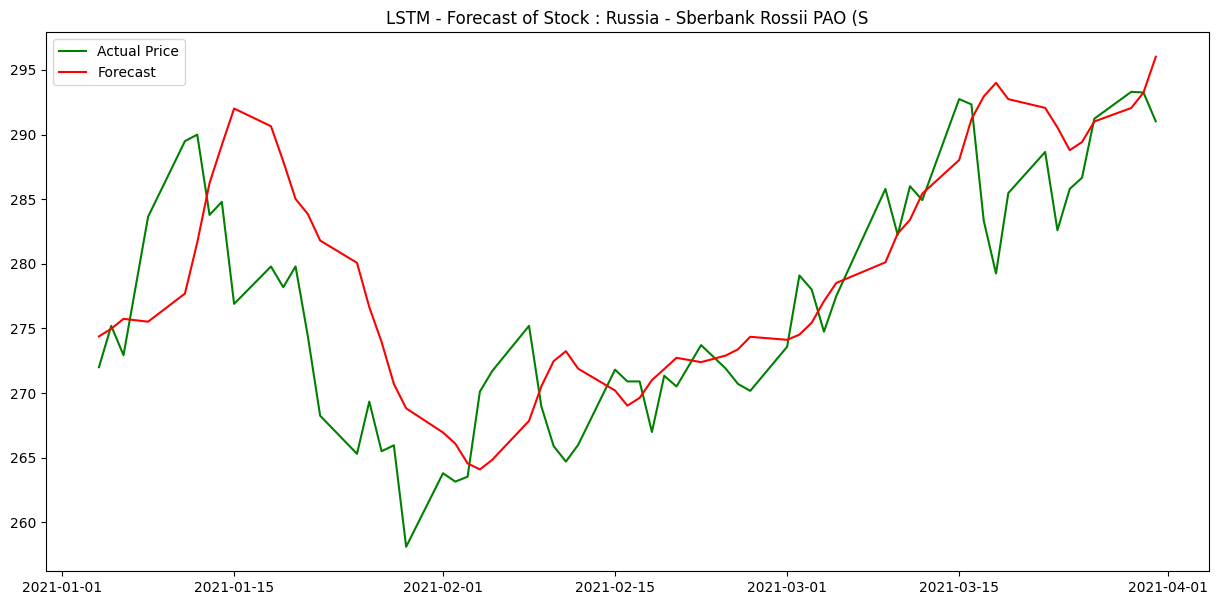

Turkey - Koc Holding AS (KCHOL)
scaled price dataset (315, 1)
scaled tensor (310, 5, 1) (310, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (63, 5, 1) (63, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1235 - root_mean_squared_error: 0.3506 - val_loss: 0.1176 - val_root_mean_squared_error: 0.3429
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0434 - root_mean_squared_error: 0.2082 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1887
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - root_mean_squared_error: 0.1116 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - root_mean_squared_error: 0.0961 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - root_mean_

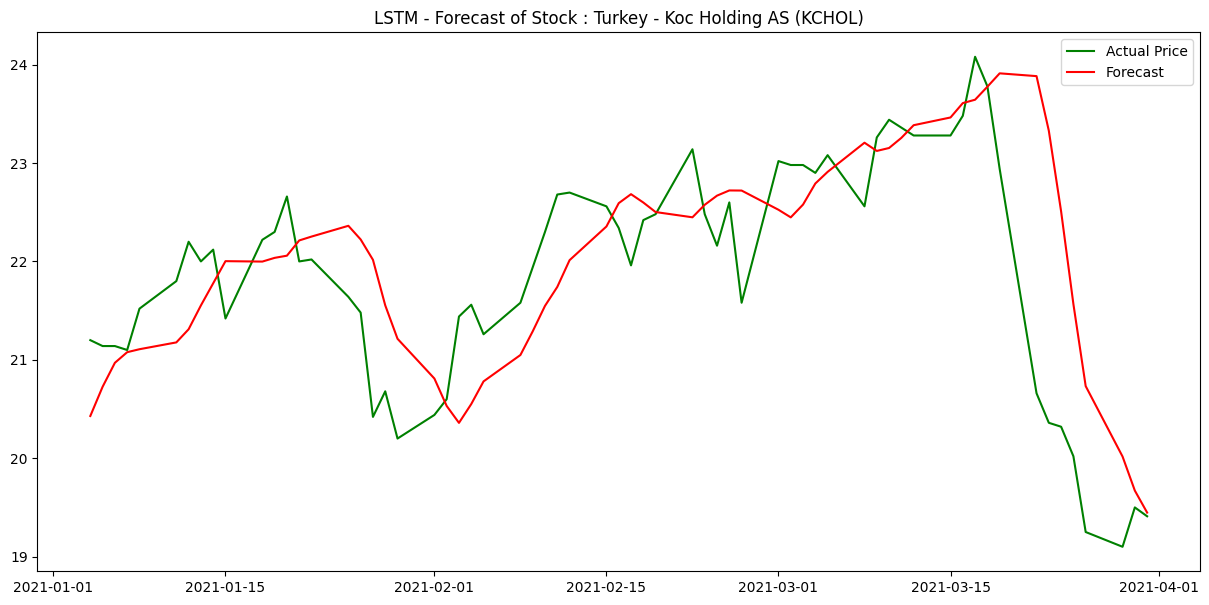

Egypt - Medinet Nasr Housing (M
scaled price dataset (305, 1)
scaled tensor (300, 5, 1) (300, 1)
training (190, 5, 1) (190, 1)
validation (48, 5, 1) (48, 1)
test (62, 5, 1) (62, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1670 - root_mean_squared_error: 0.4083 - val_loss: 0.1403 - val_root_mean_squared_error: 0.3745
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0722 - root_mean_squared_error: 0.2682 - val_loss: 0.0470 - val_root_mean_squared_error: 0.2169
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0375 - root_mean_squared_error: 0.1924 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1262 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - root_mean_squared_error: 0.1124 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - root_mea

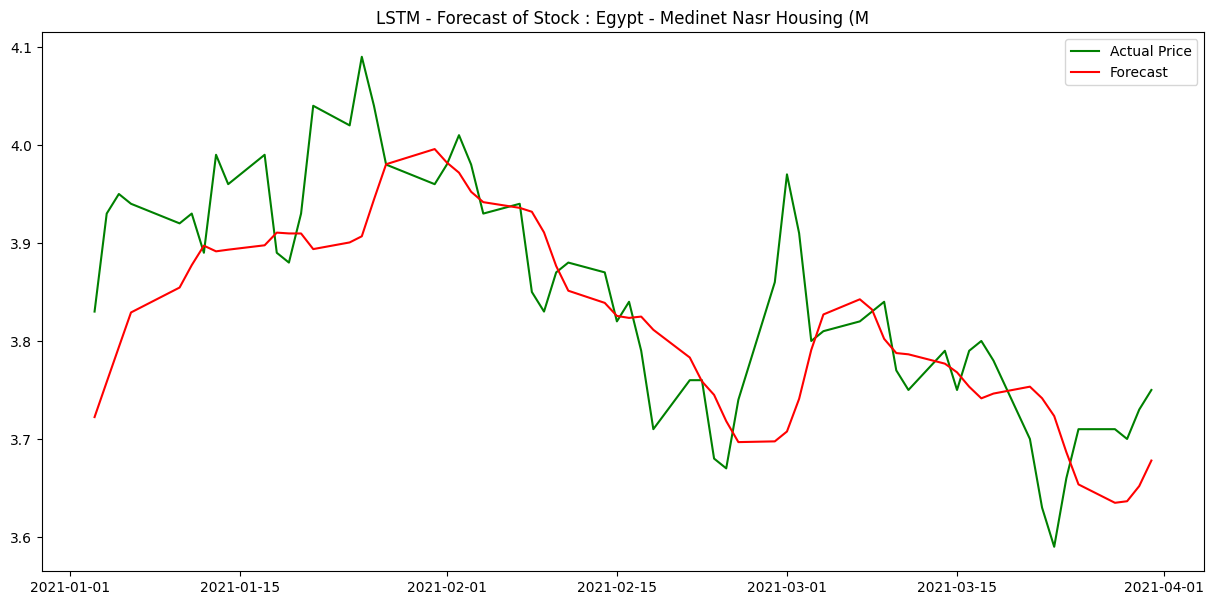

Brazil - Minerva SABrazil (BEEF
scaled price dataset (309, 1)
scaled tensor (304, 5, 1) (304, 1)
training (195, 5, 1) (195, 1)
validation (49, 5, 1) (49, 1)
test (60, 5, 1) (60, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.3203 - root_mean_squared_error: 0.5657 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2398
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1490 - root_mean_squared_error: 0.3852 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - root_mean_squared_error: 0.1768 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - root_mean_squared_error: 0.1318 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1573
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0190 - root_mean_squared_error: 0.1375 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - root_mean_

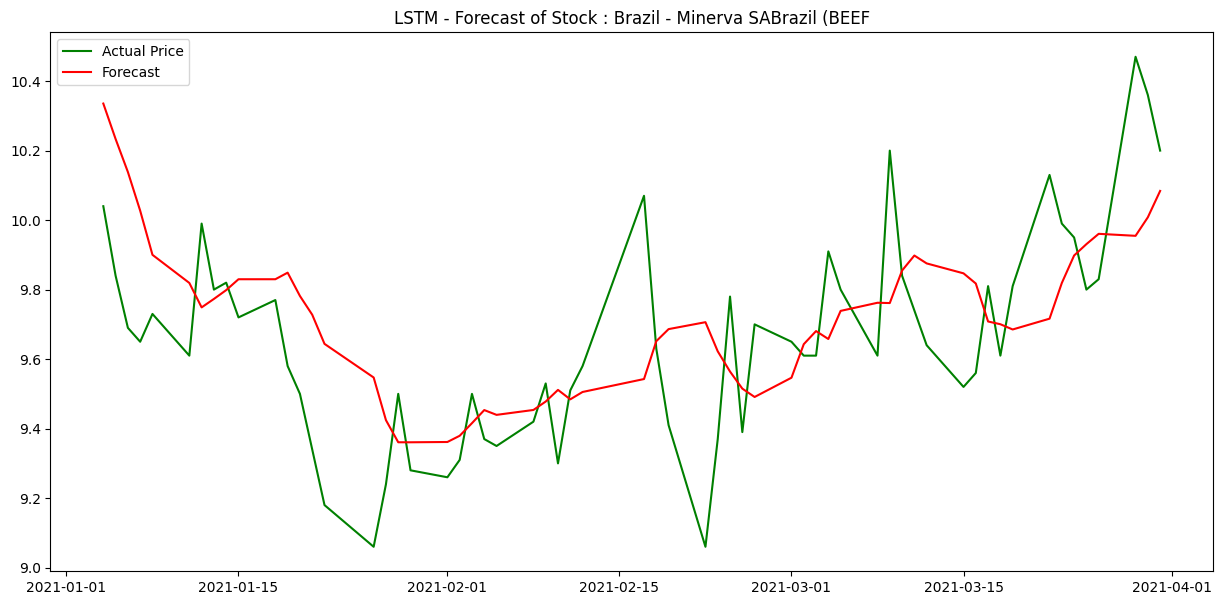

Argentina - Pampa Energia SA (P
scaled price dataset (300, 1)
scaled tensor (295, 5, 1) (295, 1)
training (188, 5, 1) (188, 1)
validation (47, 5, 1) (47, 1)
test (60, 5, 1) (60, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1453 - root_mean_squared_error: 0.3797 - val_loss: 0.5255 - val_root_mean_squared_error: 0.7249
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0743 - root_mean_squared_error: 0.2716 - val_loss: 0.2876 - val_root_mean_squared_error: 0.5363
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - root_mean_squared_error: 0.1767 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1519
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1055 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1569
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - root_m

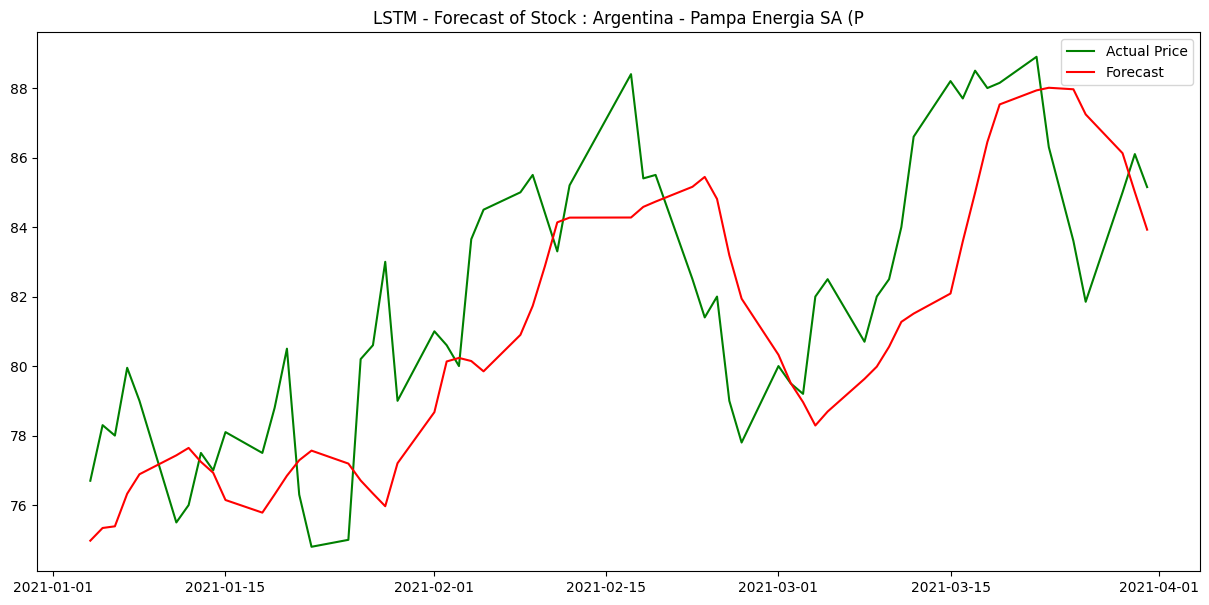

Colombia - Cementos Argos SA (C
scaled price dataset (303, 1)
scaled tensor (298, 5, 1) (298, 1)
training (189, 5, 1) (189, 1)
validation (48, 5, 1) (48, 1)
test (61, 5, 1) (61, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2041 - root_mean_squared_error: 0.4499 - val_loss: 0.1625 - val_root_mean_squared_error: 0.4031
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0906 - root_mean_squared_error: 0.3005 - val_loss: 0.0628 - val_root_mean_squared_error: 0.2506
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0356 - root_mean_squared_error: 0.1862 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - root_mean

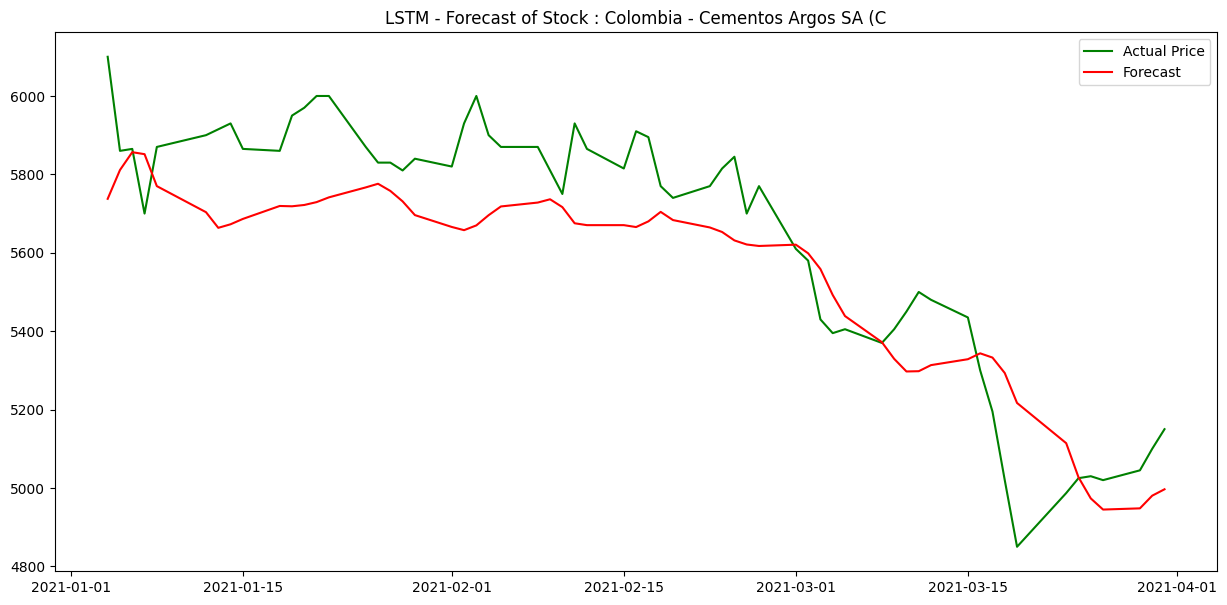

South Africa - Impala Platinum 
scaled price dataset (314, 1)
scaled tensor (309, 5, 1) (309, 1)
training (197, 5, 1) (197, 1)
validation (50, 5, 1) (50, 1)
test (62, 5, 1) (62, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1166 - root_mean_squared_error: 0.3410 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3710
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0495 - root_mean_squared_error: 0.2215 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2075
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - root_mean_squared_error: 0.1015 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - root_mean_squared_error: 0.0744 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - root_mean_

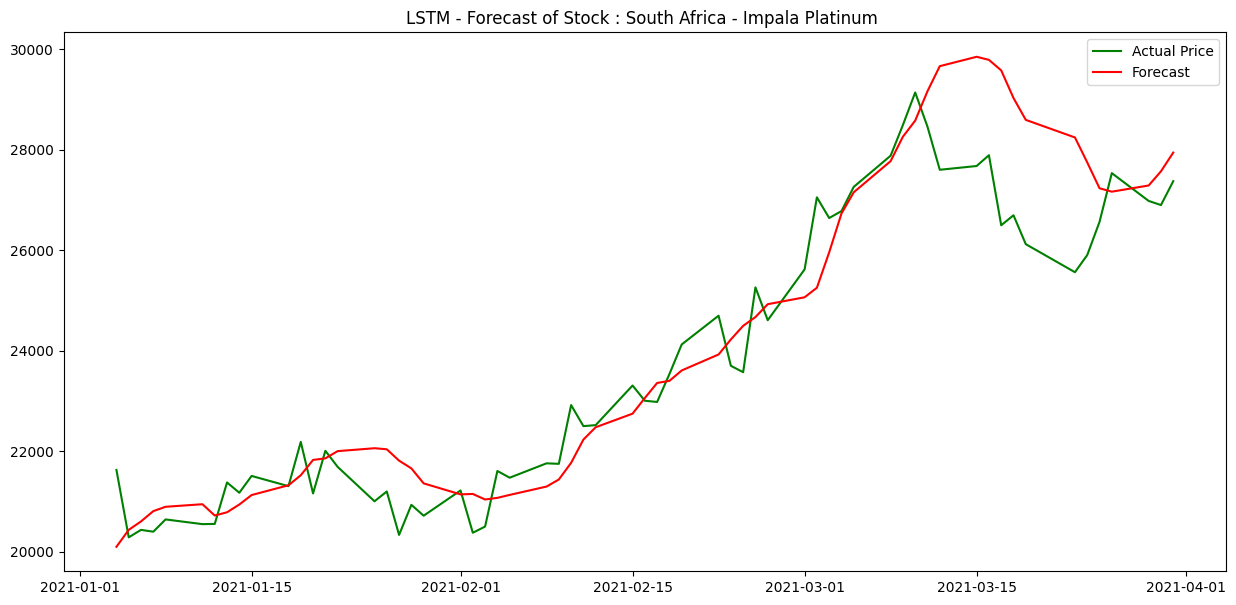

South Korea - Dongkuk Steel Mil
scaled price dataset (341, 1)
scaled tensor (336, 5, 1) (336, 1)
training (213, 5, 1) (213, 1)
validation (54, 5, 1) (54, 1)
test (69, 5, 1) (69, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0514 - root_mean_squared_error: 0.2259 - val_loss: 0.0793 - val_root_mean_squared_error: 0.2816
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0172 - root_mean_squared_error: 0.1308 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1408
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - root_mean_

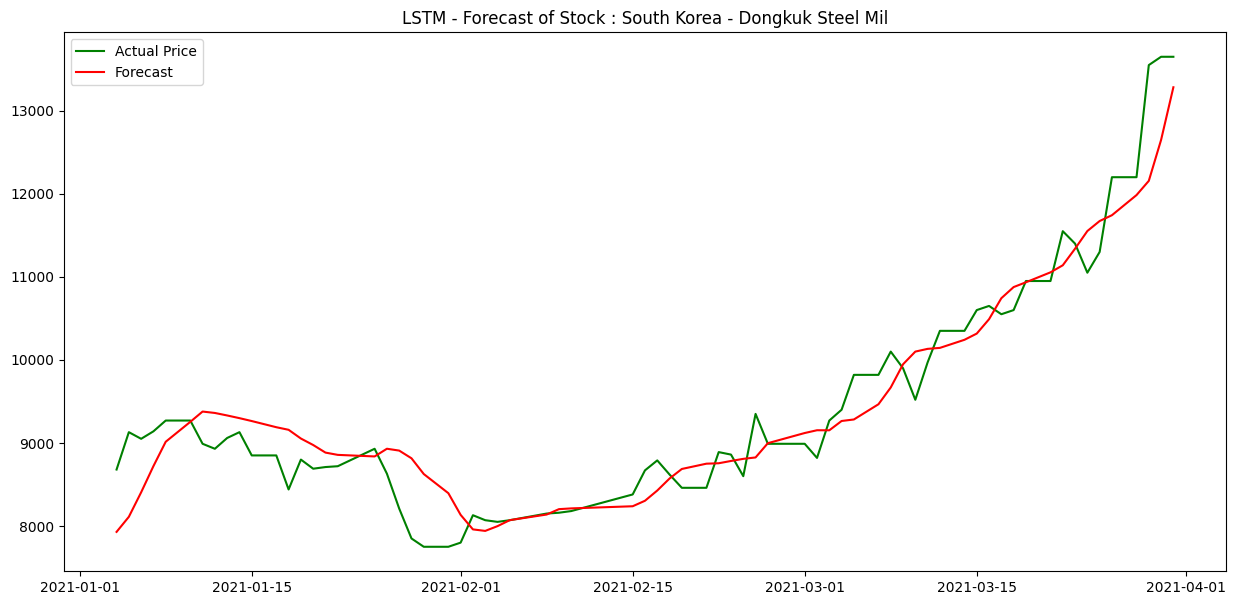

In [14]:
for key in df_dic:
    print(key)
    lstm_model[key], forecast_lstm[key] = lstm(df_dic[key],name=key)

As expected the LSTM model as an ensemble model outperforms the ARIMA model because is more suitable for non-linear patterns and it can captures long-term dependencies and changing path over time which are common aspect of stock prices.

### Trading algorithm with Bollinger bands

In [15]:
def calculate_bollinger_bands(forecast_price, window, num_std=2):

    # Calculate the moving average (MA) and standard deviation (σ)
    ma = forecast_price.rolling(window=window).mean()
    std = forecast_price.rolling(window=window).std()

    # Calculate Upper and Lower Bollinger Bands
    UB = ma + num_std * std
    LB = ma - num_std * std

    # #volatility indicator calculation
    # bandwidth = (UB - LB) / UB
    # mean_bandwidth = np.mean(bandwidth)

    # # Calculate standard deviation of bandwidth
    # std_bandwidth = np.std(bandwidth)
    # # Calculating threshold
    # threshold = mean_bandwidth - (num_std * std_bandwidth)

    # storing the results in new df
    bollinger_bands = pd.DataFrame({
        'MA': ma,
        'UB': UB,
        'LB': LB,
    })

    return bollinger_bands

In [16]:
def trading_algo(rolling_window,forecast,stoploss,initial_capital,LB_threshold,max_hold,min_margin,name):

    bollinger_bands = calculate_bollinger_bands(forecast['Test_Predictions'],window = rolling_window)
    df = pd.merge(forecast, bollinger_bands, on='Date', how='inner')

    running_capital = last_returns = initial_capital
    hold_counter = 0
    stocks = 0
    prev = []
    lower_band = []

    # DataFrame to store signals
    signals_df = pd.DataFrame(index=df.index, columns=['Buy', 'Sell', 'Hold'])

    for i in range(len(df)):
        current_price = df.iloc[i]['Actuals']
        index = df.index[i]
        upper_band = df.iloc[i]['UB']
        lower_band.append(df.iloc[i]['LB'])
        prev.append(current_price)

        #additional thresholds, range around band
        condition_above = current_price <= (1 + LB_threshold) * lower_band[-1]
        # condition_below = current_price >= (1 - LB_threshold) * lower_band[-1]
        # nearLB = (1 - 0.05) * lower_band

        if len(prev) > 1:
          if stocks == 0 and running_capital != 0:
              # BUY signal
              if (prev[-2] < lower_band[-2]) and (condition_above): #condition to assess potential upward trend for buying, trend around lowerband
                  stocks = running_capital / current_price
                  signals_df.at[index, 'Buy'] = current_price
                  running_capital = 0
                  print(f'{index}: Buy {stocks:.2f} stocks @ {current_price:.2f}')
                  stop_loss_price = current_price
                  locked_price = current_price #for profit condition
          elif stocks > 0:
              # update stoploss mark
              if current_price > stop_loss_price:
                  stop_loss_price = current_price
              # Stop loss trigger
              if current_price < (1 - stoploss) * stop_loss_price: #overrides profit conditions incase of loss, ensures minimized loss
                  running_capital += stocks * current_price
                  stocks = 0
                  stop_loss_price = 0
                  signals_df.at[index, 'Sell'] = current_price
                  print(f'{index}: Stoploss trigger: Sell @ {current_price:.2f}')
                  diff = running_capital-initial_capital
                  print(f'Estimated Returns:{running_capital:.2f}, Estimated Gain/Loss:{diff:.2f}')
                  if running_capital != initial_capital:
                    last_returns = running_capital
              # SELL signal for profit
              elif (current_price > upper_band and current_price > ((1+min_margin)*locked_price)) or (hold_counter >= max_hold and current_price > ((1+min_margin)*locked_price)): #condition to minimize hold period and maximize returns
                  running_capital += stocks * current_price
                  stocks = 0
                  stop_loss_price = 0
                  signals_df.at[index, 'Sell'] = current_price
                  print(f'{index}: Sell @ {current_price}')
                  profit = running_capital-initial_capital
                  print(f'Estimated Returns:{running_capital:.2f}, Estimated Gain/Loss:{profit:.2f}')
                  if running_capital != initial_capital:
                    last_returns = running_capital
              # HOLD
              else:
                  signals_df.at[index, 'Hold'] = current_price
                  hold_counter +=1
                  print(f'{index}: Hold stocks')


    return_per = ((last_returns-initial_capital)/initial_capital)*100
    print(f"Return of capital is {return_per:.1f}%")
    plot_signals(df, signals_df,name)



def plot_signals(df,signals_df,name):
      plt.figure(figsize=(15, 7))
      plt.plot(df['Test_Predictions'], color='Red', label='Predicted Price')
      plt.plot(df['Actuals'], color='blue', label='Actual Price')
      plt.plot(df['MA'], color='Orange', label='Moving Averge')
      plt.fill_between(df.index,df['UB'], df['LB'], alpha=0.3, label = "Bollinger - Upper and lower bands")

      # Scatter markers for Buy, Sell, and Hold signals
      plt.scatter(signals_df.index, signals_df['Buy'], color='green', marker='^',s=200, label='Buy Signal')
      plt.scatter(signals_df.index, signals_df['Sell'], color='red', marker='v',s=200, label='Sell Signal')

      plt.title(f"Stock Forecast of {name}")
      plt.legend()
      plt.show()
     

2021-01-26 00:00:00: Buy 371.28 stocks @ 269.34
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-20 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-26 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold st

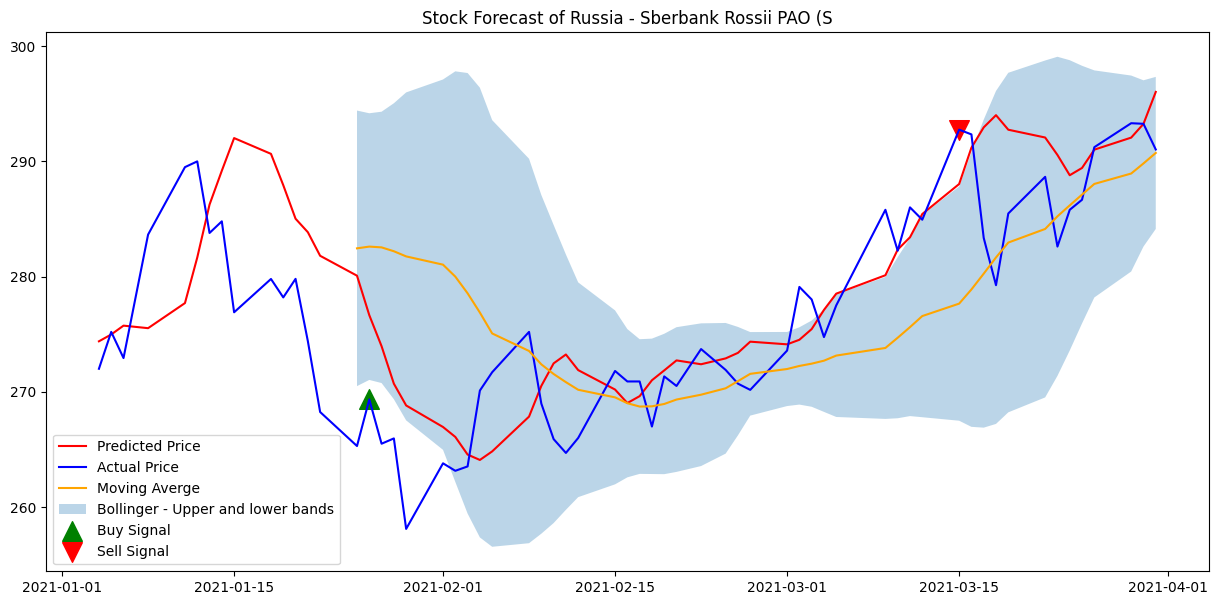

2021-01-28 00:00:00: Buy 4835.59 stocks @ 20.68
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Sell @ 22.68
Estimated Returns:109671.18, Estimated Gain/Loss:9671.18
2021-03-23 00:00:00: Buy 5386.60 stocks @ 20.36
2021-03-24 00:00:00: Hold stocks
2021-03-25 00:00:00: Hold stocks
2021-03-26 00:00:00: Hold stocks
2021-03-29 00:00:00: Hold stocks
2021-03-30 00:00:00: Hold stocks
2021-03-31 00:00:00: Hold stocks
Return of capital is 9.7%


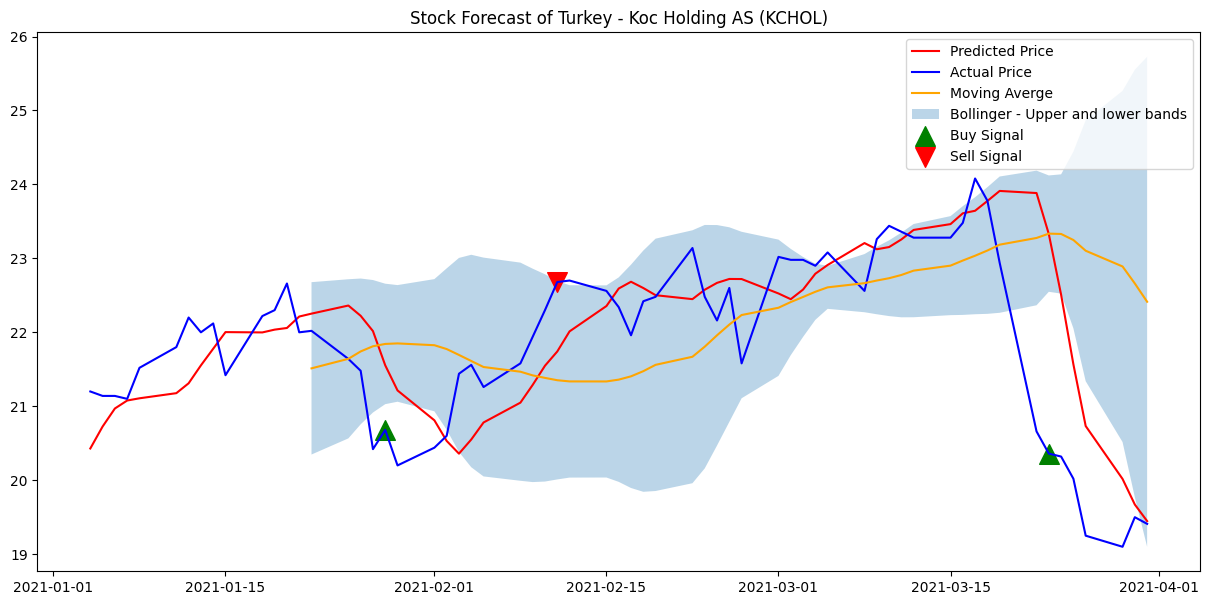

2021-02-09 00:00:00: Buy 26109.66 stocks @ 3.83
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-14 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-21 00:00:00: Hold stocks
2021-02-22 00:00:00: Hold stocks
2021-02-23 00:00:00: Hold stocks
2021-02-24 00:00:00: Hold stocks
2021-02-25 00:00:00: Hold stocks
2021-02-28 00:00:00: Hold stocks
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-07 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold stocks
2021-03-10 00:00:00: Hold stocks
2021-03-11 00:00:00: Hold stocks
2021-03-14 00:00:00: Hold stocks
2021-03-15 00:00:00: Hold stocks
2021-03-16 00:00:00: Hold stocks
2021-03-17 00:00:00: Hold stocks
2021-03-18 00:00:00: Hold stocks
2021-03-21 00:00:00: Hold stocks
2021-03-22 00:00:00: Hold st

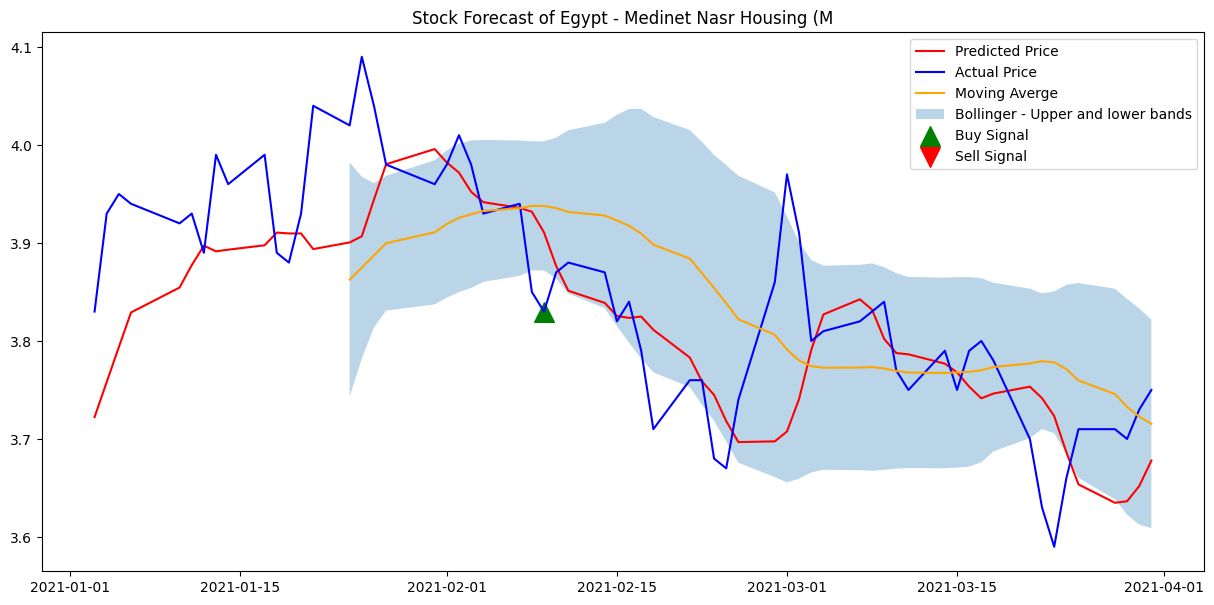

2021-01-26 00:00:00: Buy 11037.53 stocks @ 9.06
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-11 00:00:00: Hold stocks
2021-02-12 00:00:00: Hold stocks
2021-02-17 00:00:00: Sell @ 10.07
Estimated Returns:111147.90, Estimated Gain/Loss:11147.90
Return of capital is 11.1%


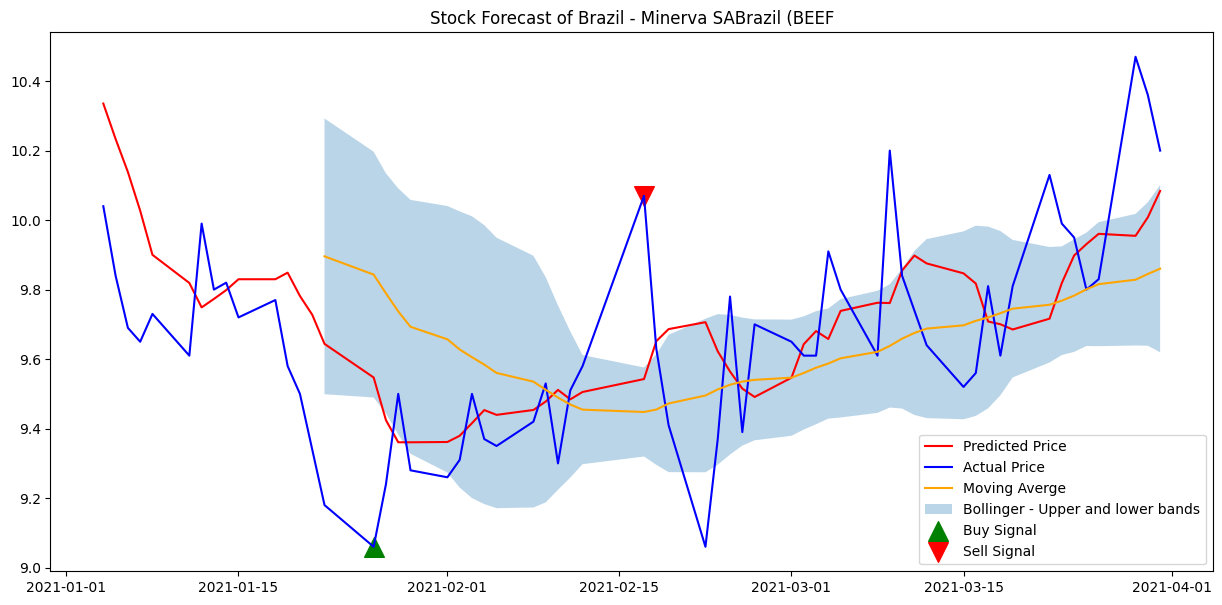

2021-01-25 00:00:00: Buy 1333.33 stocks @ 75.00
2021-01-26 00:00:00: Hold stocks
2021-01-27 00:00:00: Hold stocks
2021-01-28 00:00:00: Sell @ 83.0
Estimated Returns:110666.67, Estimated Gain/Loss:10666.67
2021-02-26 00:00:00: Buy 1422.45 stocks @ 77.80
2021-03-01 00:00:00: Hold stocks
2021-03-02 00:00:00: Hold stocks
2021-03-03 00:00:00: Hold stocks
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold stocks
2021-03-10 00:00:00: Hold stocks
2021-03-11 00:00:00: Hold stocks
2021-03-12 00:00:00: Sell @ 86.6
Estimated Returns:123184.23, Estimated Gain/Loss:23184.23
Return of capital is 23.2%


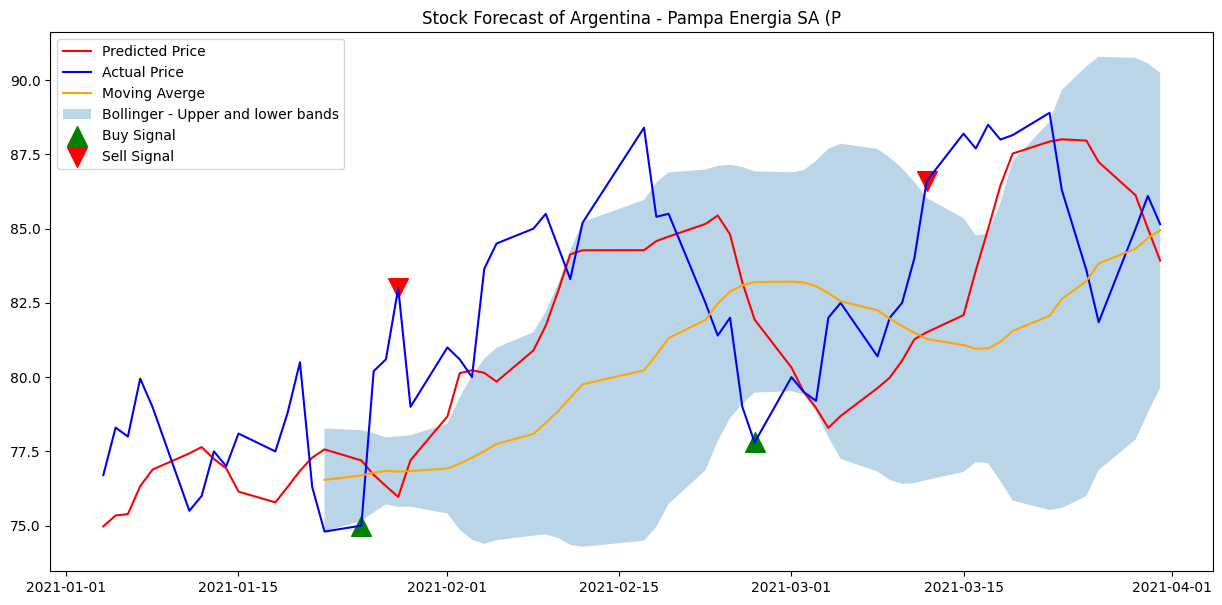

2021-03-03 00:00:00: Buy 18.42 stocks @ 5430.00
2021-03-04 00:00:00: Hold stocks
2021-03-05 00:00:00: Hold stocks
2021-03-08 00:00:00: Hold stocks
2021-03-09 00:00:00: Hold stocks
2021-03-10 00:00:00: Hold stocks
2021-03-11 00:00:00: Hold stocks
2021-03-12 00:00:00: Hold stocks
2021-03-15 00:00:00: Hold stocks
2021-03-16 00:00:00: Hold stocks
2021-03-17 00:00:00: Hold stocks
2021-03-18 00:00:00: Hold stocks
2021-03-19 00:00:00: Stoploss trigger: Sell @ 4850.00
Estimated Returns:89318.60, Estimated Gain/Loss:-10681.40
2021-03-23 00:00:00: Buy 17.91 stocks @ 4987.00
2021-03-24 00:00:00: Hold stocks
2021-03-25 00:00:00: Hold stocks
2021-03-26 00:00:00: Hold stocks
2021-03-29 00:00:00: Hold stocks
2021-03-30 00:00:00: Hold stocks
2021-03-31 00:00:00: Hold stocks
Return of capital is -10.7%


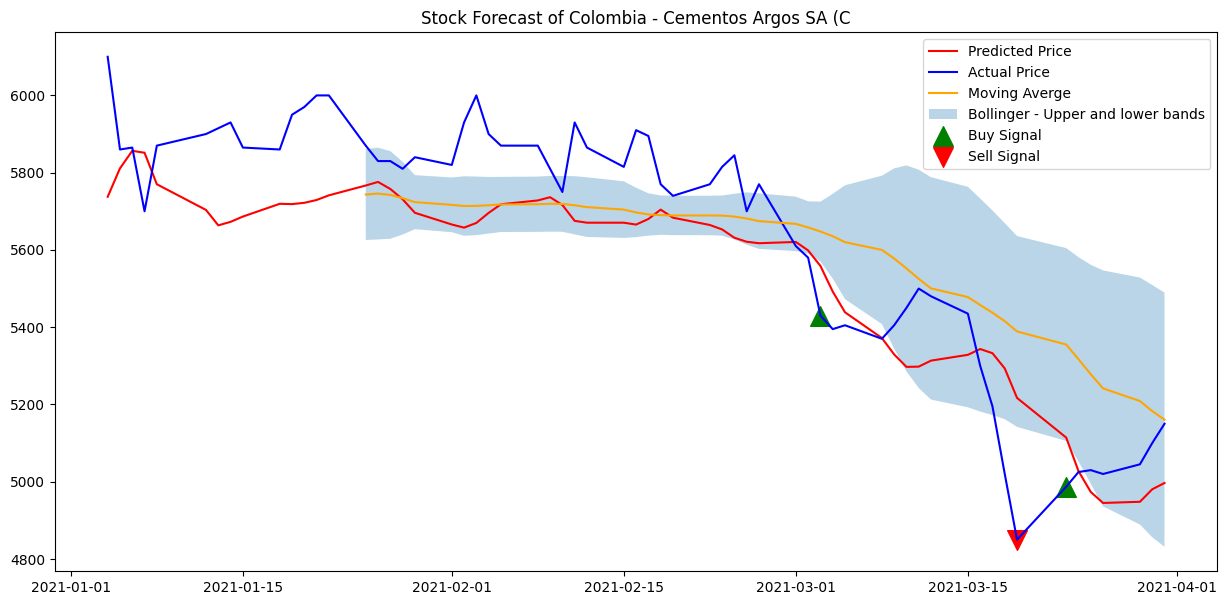

2021-02-03 00:00:00: Buy 4.88 stocks @ 20502.00
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Sell @ 22919.0
Estimated Returns:111789.09, Estimated Gain/Loss:11789.09
Return of capital is 11.8%


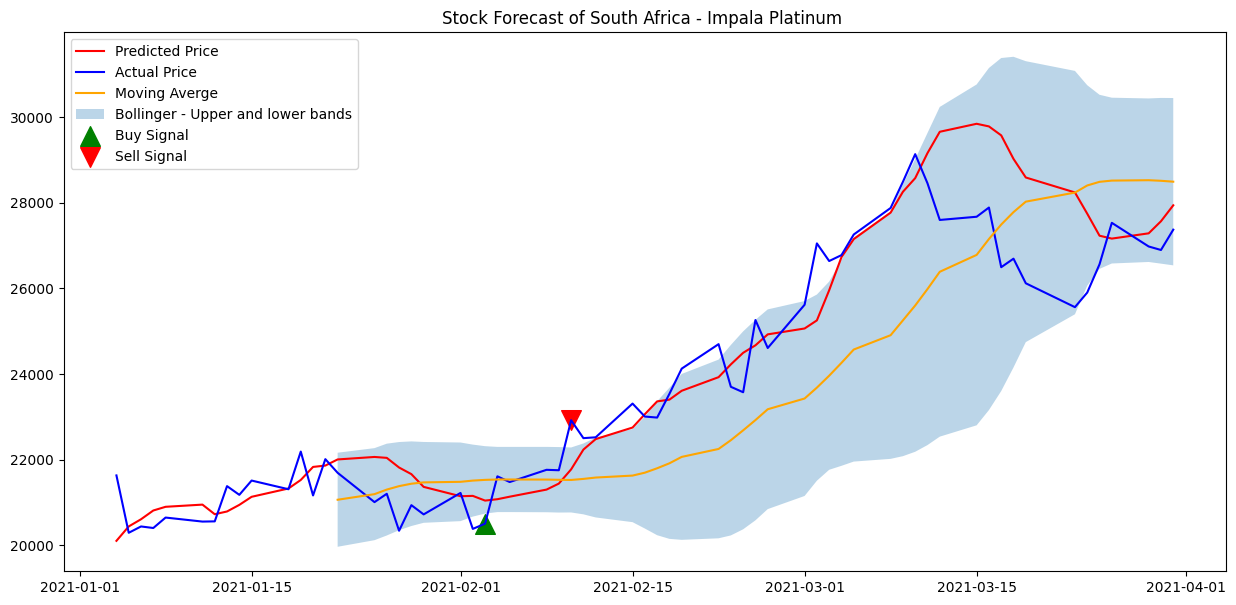

2021-01-27 00:00:00: Buy 12.18 stocks @ 8210.00
2021-01-28 00:00:00: Hold stocks
2021-01-29 00:00:00: Hold stocks
2021-01-31 00:00:00: Hold stocks
2021-02-01 00:00:00: Hold stocks
2021-02-02 00:00:00: Hold stocks
2021-02-03 00:00:00: Hold stocks
2021-02-04 00:00:00: Hold stocks
2021-02-05 00:00:00: Hold stocks
2021-02-08 00:00:00: Hold stocks
2021-02-09 00:00:00: Hold stocks
2021-02-10 00:00:00: Hold stocks
2021-02-15 00:00:00: Hold stocks
2021-02-16 00:00:00: Hold stocks
2021-02-17 00:00:00: Hold stocks
2021-02-18 00:00:00: Hold stocks
2021-02-19 00:00:00: Hold stocks
2021-02-21 00:00:00: Hold stocks
2021-02-22 00:00:00: Sell @ 8890.0
Estimated Returns:108282.58, Estimated Gain/Loss:8282.58
Return of capital is 8.3%


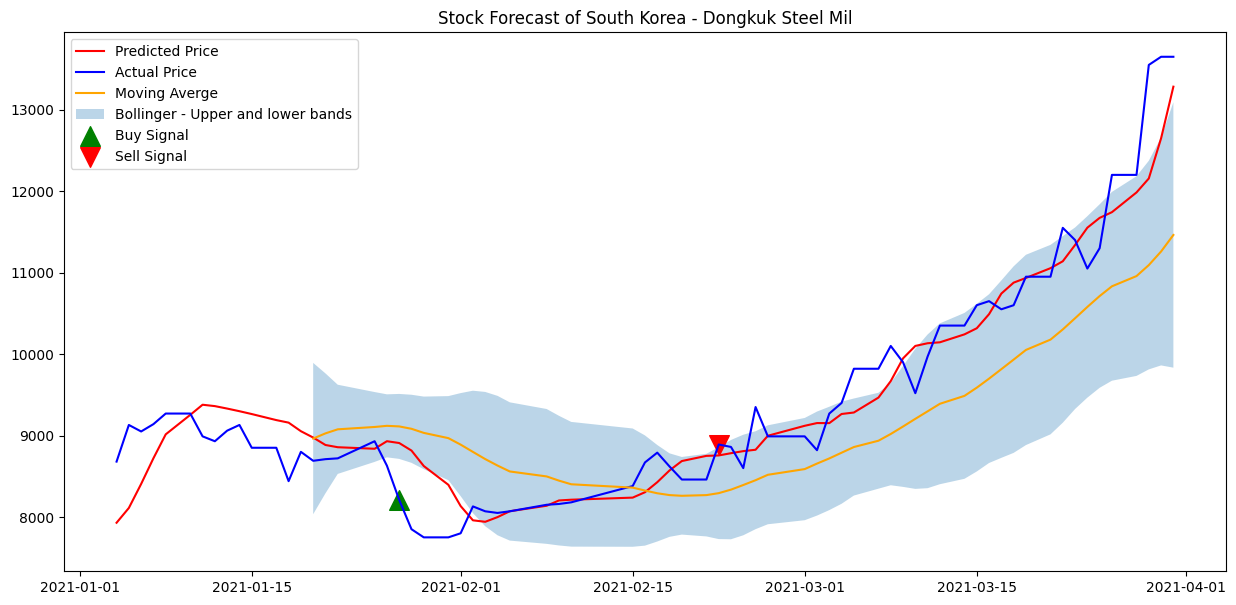

In [17]:
for key in df_dic:
    trading_algo(rolling_window=15,forecast=forecast_lstm[key],stoploss=.1,initial_capital = 100000,LB_threshold = 0.001,max_hold=5,min_margin=0.08,name=key)

### Conclusions

The current solution consisting in an LSTM model for time series forecasting combined with the Bollinger Bands strategy with triggers and customised parameters achieves the objective of resulting in no losses and maximum returns while decreasing the hold period. Altough in this specific case the result was achieved, larger and different datasets describing more complex trends require more fine-tuning. The different parameters can be changed in order to fine tune the algorithm on a different dataset. The minimum margin parameter can be adjusted according to the different trends: smaller values are better for downward trend while greater values are better for upward trends. The max_hold parameter determine the lenght of the maximum hold period before to sell the stocks. The sell signal is generated when the current price surpasses the upper Bollinger Band or if the maximum holding period has been reached. Additionally, the algorithm checks if the current price is above a minimum margin from the locked price in order to enforce the maximum possible profit.
The buy signal is generated when the previous closing price is below the lower Bollinger Band, and the current price is within a specified threshold above the lower Bollinger Band.
The minimum loss is achieved with the stop-loss trigger enforcing the sale of the stocks when the current price falls below a certain percentage of the stop-loss price.